#### DSNY_Frequencies
https://data.cityofnewyork.us/City-Government/DSNY-Frequencies-Map-/5qcq-w32p
Citywide DSNY frequency boundaries for collection operation (refuse, recycling, organics, bulk items). These boundaries are sub-divisions of DSNY sections, Data Last Updated: April 10, 2024

DISTRICT:
- DSNY-Zone+District. 
- DSNY Zones are Manhattan (MN), Bronx (BX), Brooklyn North (BKN), Brooklyn South (BKS), Queens East (QE), Queens West (QW), and Staten Island (SI). 
- NYC Boroughs are divided into Districts, which in this data set are written as 2 digit numbers; 
- range is 01 to 18. Districts contain the same boundaries as NYC Community Districts.

SECTION:
- DSNY Districts are divided into Sections. 
- Sections are single digit numbers with a range of 1 to 5.

SCHEDULECODE :
- Boro-Code+District+Section+Frequency. 
- Boro codes are 1=Manhattan, 2=Bronx, 3=Brooklyn, 4=Queens, and 5=Staten Island. 
- NYC Boroughs are divided into Districts, which in this dataset are written as 2 digit numbers; range is 01 to 18. Districts contain the same boundaries as NYC Community Districts. Districts are divided into DSNY Sections which are single digit numbers with a range of 1 to 5.
- Frequencies are letter codes used by DCP to indicate refuse collection frequency; range is A to E; A = Mon, Wed, Fri; B = Tue, Thu, Sat; C = Mon, Thu; D = Tue, Fri; and E = Wed, Sat. 

FREQUENCY: A = Mon, Wed, Fri; B = Tue, Thu, Sat; C = Mon, Thu; D = Tue, Fri; E = Wed, Sat. 


In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
df_Freq = pd.read_csv('DSNY_Frequencies_20240412.csv')
df_Freq.head()

DISTRICT SECTION FREQUENCY SCHEDULECODE FREQ_REFUSE FREQ_RECYCLING  \
0     QE14   QE141         E        4141E    Wed, Sat            Wed   
1    BKN05  BKN051         E        3051E    Wed, Sat            Wed   
2     QE11   QE113         C        4113C    Mon, Thu            Mon   
3    BKS12  BKS121         C        3121C    Mon, Thu            Thu   
4     BX11   BX111         D        2111D    Tue, Fri            Tue   

  FREQ_ORGANICS FREQ_BULK  ObjectID    SHAPE_Area  SHAPE_Length  \
0           Wed       Sat       556  1.022362e+07  14619.983346   
1           Wed  Wed, Sat       195  8.213492e+06  13470.744483   
2           Mon       Thu       497  1.125539e+07  20609.172110   
3           Thu  Mon, Thu       274  5.662723e+06   9954.084598   
4           NaN  Tue, Fri       135  9.385268e+06  18323.083457   

                                        multipolygon  FREQ_EWASTE  \
0  MULTIPOLYGON (((-73.8428890669 40.5741971688, ...          NaN   
1  MULTIPOLYGON (((-73.8847034837 40.6722342021, ...          NaN   
2  MULTIPOLYGON (((-73.7923653652 40.7530196389, ...          NaN   
3  MULTIPOLYGON (((-73.9982649635 40.6360058696, ...          NaN   
4  MULTIPOLYGON (((-73.8542483533 40.8538320914, ...          NaN   

  FREQ_RESFUSEID  
0        QE141WS  
1       BKN051WS  
2        QE113MH  
3       BKS121MH  
4        BX111TF

In [3]:
df_Freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DISTRICT        610 non-null    object 
 1   SECTION         610 non-null    object 
 2   FREQUENCY       610 non-null    object 
 3   SCHEDULECODE    610 non-null    object 
 4   FREQ_REFUSE     610 non-null    object 
 5   FREQ_RECYCLING  609 non-null    object 
 6   FREQ_ORGANICS   427 non-null    object 
 7   FREQ_BULK       608 non-null    object 
 8   ObjectID        610 non-null    int64  
 9   SHAPE_Area      610 non-null    float64
 10  SHAPE_Length    610 non-null    float64
 11  multipolygon    610 non-null    object 
 12  FREQ_EWASTE     0 non-null      float64
 13  FREQ_RESFUSEID  610 non-null    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 66.8+ KB


FREQ_EWASTE: Appears to have no entries (all null values)

Drop FREQ_EWASTE 

In [4]:
# Dropping the 'FREQ_EWASTE' column due to all null values
df_Freq = df_Freq.drop(columns=['FREQ_EWASTE'])

In [5]:
# Extracting features from 'SCHEDULECODE'
# SCHEDULECODE format: Boro-Code (1 digit) + District (2 digits) + Section (1 digit) + Frequency (1 letter)
df_Freq['Borough'] = df_Freq['SCHEDULECODE'].str[0].astype(int).map({
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
})
# the two-digit district code.
df_Freq['Extracted_District'] = df_Freq['SCHEDULECODE'].str[1:3]
# the section code within the district.
df_Freq['Extracted_Section'] = df_Freq['SCHEDULECODE'].str[3]

In [6]:
df_Freq

DISTRICT SECTION FREQUENCY SCHEDULECODE    FREQ_REFUSE FREQ_RECYCLING  \
0       QE14   QE141         E        4141E       Wed, Sat            Wed   
1      BKN05  BKN051         E        3051E       Wed, Sat            Wed   
2       QE11   QE113         C        4113C       Mon, Thu            Mon   
3      BKS12  BKS121         C        3121C       Mon, Thu            Thu   
4       BX11   BX111         D        2111D       Tue, Fri            Tue   
..       ...     ...       ...          ...            ...            ...   
605     QW03   QW031         E        4031E       Wed, Sat            Wed   
606     QW05   QW054         C        4054C       Mon, Thu            Mon   
607    BKN02  BKN024         D        3024D       Tue, Fri            Fri   
608     SI01   SI013         D        5013D       Tue, Fri            Tue   
609     MN07   MN073         A        1073A  Mon, Wed, Fri            Wed   

    FREQ_ORGANICS      FREQ_BULK  ObjectID    SHAPE_Area  SHAPE_Length  \
0             Wed            Sat       556  1.022362e+07  14619.983346   
1             Wed       Wed, Sat       195  8.213492e+06  13470.744483   
2             Mon            Thu       497  1.125539e+07  20609.172110   
3             Thu       Mon, Thu       274  5.662723e+06   9954.084598   
4             NaN       Tue, Fri       135  9.385268e+06  18323.083457   
..            ...            ...       ...           ...           ...   
605           Wed       Wed, Sat       393  1.085562e+07  14199.352894   
606           Mon            Thu       419  4.119600e+07  34773.881643   
607           Fri       Tue, Fri       175  4.272816e+06  11061.362470   
608           NaN       Tue, Fri       570  2.967774e+07  38343.262097   
609           Sat  Mon, Wed, Fri        39  4.833643e+06   9089.053108   

                                          multipolygon FREQ_RESFUSEID  \
0    MULTIPOLYGON (((-73.8428890669 40.5741971688, ...        QE141WS   
1    MULTIPOLYGON (((-73.8847034837 40.6722342021, ...       BKN051WS   
2    MULTIPOLYGON (((-73.7923653652 40.7530196389, ...        QE113MH   
3    MULTIPOLYGON (((-73.9982649635 40.6360058696, ...       BKS121MH   
4    MULTIPOLYGON (((-73.8542483533 40.8538320914, ...        BX111TF   
..                                                 ...            ...   
605  MULTIPOLYGON (((-73.8872278409 40.7553633065, ...        QW031WS   
606  MULTIPOLYGON (((-73.8582517096 40.7027965373, ...        QW054MH   
607  MULTIPOLYGON (((-73.9726874601 40.6874151942, ...       BKN024TF   
608  MULTIPOLYGON (((-74.1313098544 40.6263283429, ...        SI013TF   
609  MULTIPOLYGON (((-73.9773651017 40.7844644407, ...       MN073MWF   

           Borough Extracted_District Extracted_Section  
0           Queens                 14                 1  
1         Brooklyn                 05                 1  
2           Queens                 11                 3  
3         Brooklyn                 12                 1  
4            Bronx                 11                 1  
..             ...                ...               ...  
605         Queens                 03                 1  
606         Queens                 05                 4  
607       Brooklyn                 02                 4  
608  Staten Island                 01                 3  
609      Manhattan                 07                 3  

[610 rows x 16 columns]

Normalizing the FREQ_ column to see how many days a week refuse is collected

In [7]:
# Define a function to count the number of days listed in each entry
def count_days(day_string):
    if pd.isna(day_string):
        return 0  # Returning 0 if there are no collection days listed (i.e., NaN entries)
    return len(day_string.split(','))

# Apply the function to the 'FREQ_REFUSE' column to count the number of collection days
df_Freq['Count_FREQ_REFUSE'] = df_Freq['FREQ_REFUSE'].apply(count_days)
df_Freq['Count_FREQ_RECYCLING'] = df_Freq['FREQ_RECYCLING'].apply(count_days)
df_Freq['Count_FREQ_ORGANICS'] = df_Freq['FREQ_ORGANICS'].apply(count_days)
df_Freq['Count_FREQ_BULK'] = df_Freq['FREQ_BULK'].apply(count_days)

In [8]:
df_Freq['FREQUENCY'].value_counts(normalize=True,ascending=False)*100

FREQUENCY
E    23.606557
C    23.606557
D    23.606557
A    14.754098
B    14.426230
Name: proportion, dtype: float64

In [9]:
df_Freq['Count_FREQ_REFUSE'].value_counts(normalize=True,ascending=False)*100

Count_FREQ_REFUSE
2    70.819672
3    29.180328
Name: proportion, dtype: float64

In [10]:
df_Freq['Count_FREQ_RECYCLING'].value_counts(normalize=True,ascending=False)*100

Count_FREQ_RECYCLING
1    99.836066
0     0.163934
Name: proportion, dtype: float64

In [11]:
df_Freq['Count_FREQ_ORGANICS'].value_counts(normalize=True,ascending=False)*100

Count_FREQ_ORGANICS
1    70.0
0    30.0
Name: proportion, dtype: float64

In [12]:
df_Freq['Count_FREQ_BULK'].value_counts(normalize=True,ascending=False)*100

Count_FREQ_BULK
2    47.704918
3    29.016393
1    22.950820
0     0.327869
Name: proportion, dtype: float64

In [13]:
colors_clas = {3: 'red', 2: 'green', 1: 'yello', 0: 'grey'}

In [14]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Convert the 'multipolygon' string to a geometric object
df_Freq['geometry'] = df_Freq['multipolygon'].apply(wkt.loads)

# Create a GeoDataFrame
gdf_Freq = gpd.GeoDataFrame(df_Freq, crs="EPSG:4326", geometry='geometry')

In [15]:
df_Freq

DISTRICT SECTION FREQUENCY SCHEDULECODE    FREQ_REFUSE FREQ_RECYCLING  \
0       QE14   QE141         E        4141E       Wed, Sat            Wed   
1      BKN05  BKN051         E        3051E       Wed, Sat            Wed   
2       QE11   QE113         C        4113C       Mon, Thu            Mon   
3      BKS12  BKS121         C        3121C       Mon, Thu            Thu   
4       BX11   BX111         D        2111D       Tue, Fri            Tue   
..       ...     ...       ...          ...            ...            ...   
605     QW03   QW031         E        4031E       Wed, Sat            Wed   
606     QW05   QW054         C        4054C       Mon, Thu            Mon   
607    BKN02  BKN024         D        3024D       Tue, Fri            Fri   
608     SI01   SI013         D        5013D       Tue, Fri            Tue   
609     MN07   MN073         A        1073A  Mon, Wed, Fri            Wed   

    FREQ_ORGANICS      FREQ_BULK  ObjectID    SHAPE_Area  ...  \
0             Wed            Sat       556  1.022362e+07  ...   
1             Wed       Wed, Sat       195  8.213492e+06  ...   
2             Mon            Thu       497  1.125539e+07  ...   
3             Thu       Mon, Thu       274  5.662723e+06  ...   
4             NaN       Tue, Fri       135  9.385268e+06  ...   
..            ...            ...       ...           ...  ...   
605           Wed       Wed, Sat       393  1.085562e+07  ...   
606           Mon            Thu       419  4.119600e+07  ...   
607           Fri       Tue, Fri       175  4.272816e+06  ...   
608           NaN       Tue, Fri       570  2.967774e+07  ...   
609           Sat  Mon, Wed, Fri        39  4.833643e+06  ...   

                                          multipolygon FREQ_RESFUSEID  \
0    MULTIPOLYGON (((-73.8428890669 40.5741971688, ...        QE141WS   
1    MULTIPOLYGON (((-73.8847034837 40.6722342021, ...       BKN051WS   
2    MULTIPOLYGON (((-73.7923653652 40.7530196389, ...        QE113MH   
3    MULTIPOLYGON (((-73.9982649635 40.6360058696, ...       BKS121MH   
4    MULTIPOLYGON (((-73.8542483533 40.8538320914, ...        BX111TF   
..                                                 ...            ...   
605  MULTIPOLYGON (((-73.8872278409 40.7553633065, ...        QW031WS   
606  MULTIPOLYGON (((-73.8582517096 40.7027965373, ...        QW054MH   
607  MULTIPOLYGON (((-73.9726874601 40.6874151942, ...       BKN024TF   
608  MULTIPOLYGON (((-74.1313098544 40.6263283429, ...        SI013TF   
609  MULTIPOLYGON (((-73.9773651017 40.7844644407, ...       MN073MWF   

           Borough Extracted_District Extracted_Section Count_FREQ_REFUSE  \
0           Queens                 14                 1                 2   
1         Brooklyn                 05                 1                 2   
2           Queens                 11                 3                 2   
3         Brooklyn                 12                 1                 2   
4            Bronx                 11                 1                 2   
..             ...                ...               ...               ...   
605         Queens                 03                 1                 2   
606         Queens                 05                 4                 2   
607       Brooklyn                 02                 4                 2   
608  Staten Island                 01                 3                 2   
609      Manhattan                 07                 3                 3   

     Count_FREQ_RECYCLING  Count_FREQ_ORGANICS  Count_FREQ_BULK  \
0                       1                    1                1   
1                       1                    1                2   
2                       1                    1                1   
3                       1                    1                2   
4                       1                    0                2   
..                    ...                  ...              ...   
605                     1  

In [16]:
df_Freq['geometry']

0      MULTIPOLYGON (((-73.8428890669 40.5741971688, ...
1      MULTIPOLYGON (((-73.8847034837 40.6722342021, ...
2      MULTIPOLYGON (((-73.7923653652 40.7530196389, ...
3      MULTIPOLYGON (((-73.9982649635 40.6360058696, ...
4      MULTIPOLYGON (((-73.8542483533 40.8538320914, ...
                             ...                        
605    MULTIPOLYGON (((-73.8872278409 40.7553633065, ...
606    MULTIPOLYGON (((-73.8582517096 40.7027965373, ...
607    MULTIPOLYGON (((-73.9726874601 40.6874151942, ...
608    MULTIPOLYGON (((-74.1313098544 40.6263283429, ...
609    MULTIPOLYGON (((-73.9773651017 40.7844644407, ...
Name: geometry, Length: 610, dtype: object

In [17]:
gdf_Freq

DISTRICT SECTION FREQUENCY SCHEDULECODE    FREQ_REFUSE FREQ_RECYCLING  \
0       QE14   QE141         E        4141E       Wed, Sat            Wed   
1      BKN05  BKN051         E        3051E       Wed, Sat            Wed   
2       QE11   QE113         C        4113C       Mon, Thu            Mon   
3      BKS12  BKS121         C        3121C       Mon, Thu            Thu   
4       BX11   BX111         D        2111D       Tue, Fri            Tue   
..       ...     ...       ...          ...            ...            ...   
605     QW03   QW031         E        4031E       Wed, Sat            Wed   
606     QW05   QW054         C        4054C       Mon, Thu            Mon   
607    BKN02  BKN024         D        3024D       Tue, Fri            Fri   
608     SI01   SI013         D        5013D       Tue, Fri            Tue   
609     MN07   MN073         A        1073A  Mon, Wed, Fri            Wed   

    FREQ_ORGANICS      FREQ_BULK  ObjectID    SHAPE_Area  ...  \
0             Wed            Sat       556  1.022362e+07  ...   
1             Wed       Wed, Sat       195  8.213492e+06  ...   
2             Mon            Thu       497  1.125539e+07  ...   
3             Thu       Mon, Thu       274  5.662723e+06  ...   
4             NaN       Tue, Fri       135  9.385268e+06  ...   
..            ...            ...       ...           ...  ...   
605           Wed       Wed, Sat       393  1.085562e+07  ...   
606           Mon            Thu       419  4.119600e+07  ...   
607           Fri       Tue, Fri       175  4.272816e+06  ...   
608           NaN       Tue, Fri       570  2.967774e+07  ...   
609           Sat  Mon, Wed, Fri        39  4.833643e+06  ...   

                                          multipolygon FREQ_RESFUSEID  \
0    MULTIPOLYGON (((-73.8428890669 40.5741971688, ...        QE141WS   
1    MULTIPOLYGON (((-73.8847034837 40.6722342021, ...       BKN051WS   
2    MULTIPOLYGON (((-73.7923653652 40.7530196389, ...        QE113MH   
3    MULTIPOLYGON (((-73.9982649635 40.6360058696, ...       BKS121MH   
4    MULTIPOLYGON (((-73.8542483533 40.8538320914, ...        BX111TF   
..                                                 ...            ...   
605  MULTIPOLYGON (((-73.8872278409 40.7553633065, ...        QW031WS   
606  MULTIPOLYGON (((-73.8582517096 40.7027965373, ...        QW054MH   
607  MULTIPOLYGON (((-73.9726874601 40.6874151942, ...       BKN024TF   
608  MULTIPOLYGON (((-74.1313098544 40.6263283429, ...        SI013TF   
609  MULTIPOLYGON (((-73.9773651017 40.7844644407, ...       MN073MWF   

           Borough Extracted_District Extracted_Section Count_FREQ_REFUSE  \
0           Queens                 14                 1                 2   
1         Brooklyn                 05                 1                 2   
2           Queens                 11                 3                 2   
3         Brooklyn                 12                 1                 2   
4            Bronx                 11                 1                 2   
..             ...                ...               ...               ...   
605         Queens                 03                 1                 2   
606         Queens                 05                 4                 2   
607       Brooklyn                 02                 4                 2   
608  Staten Island                 01                 3                 2   
609      Manhattan                 07                 3                 3   

     Count_FREQ_RECYCLING  Count_FREQ_ORGANICS  Count_FREQ_BULK  \
0                       1                    1                1   
1                       1                    1                2   
2                       1                    1                1   
3                       1                    1                2   
4                       1                    0                2   
..                    ...                  ...              ...   
605                     1  

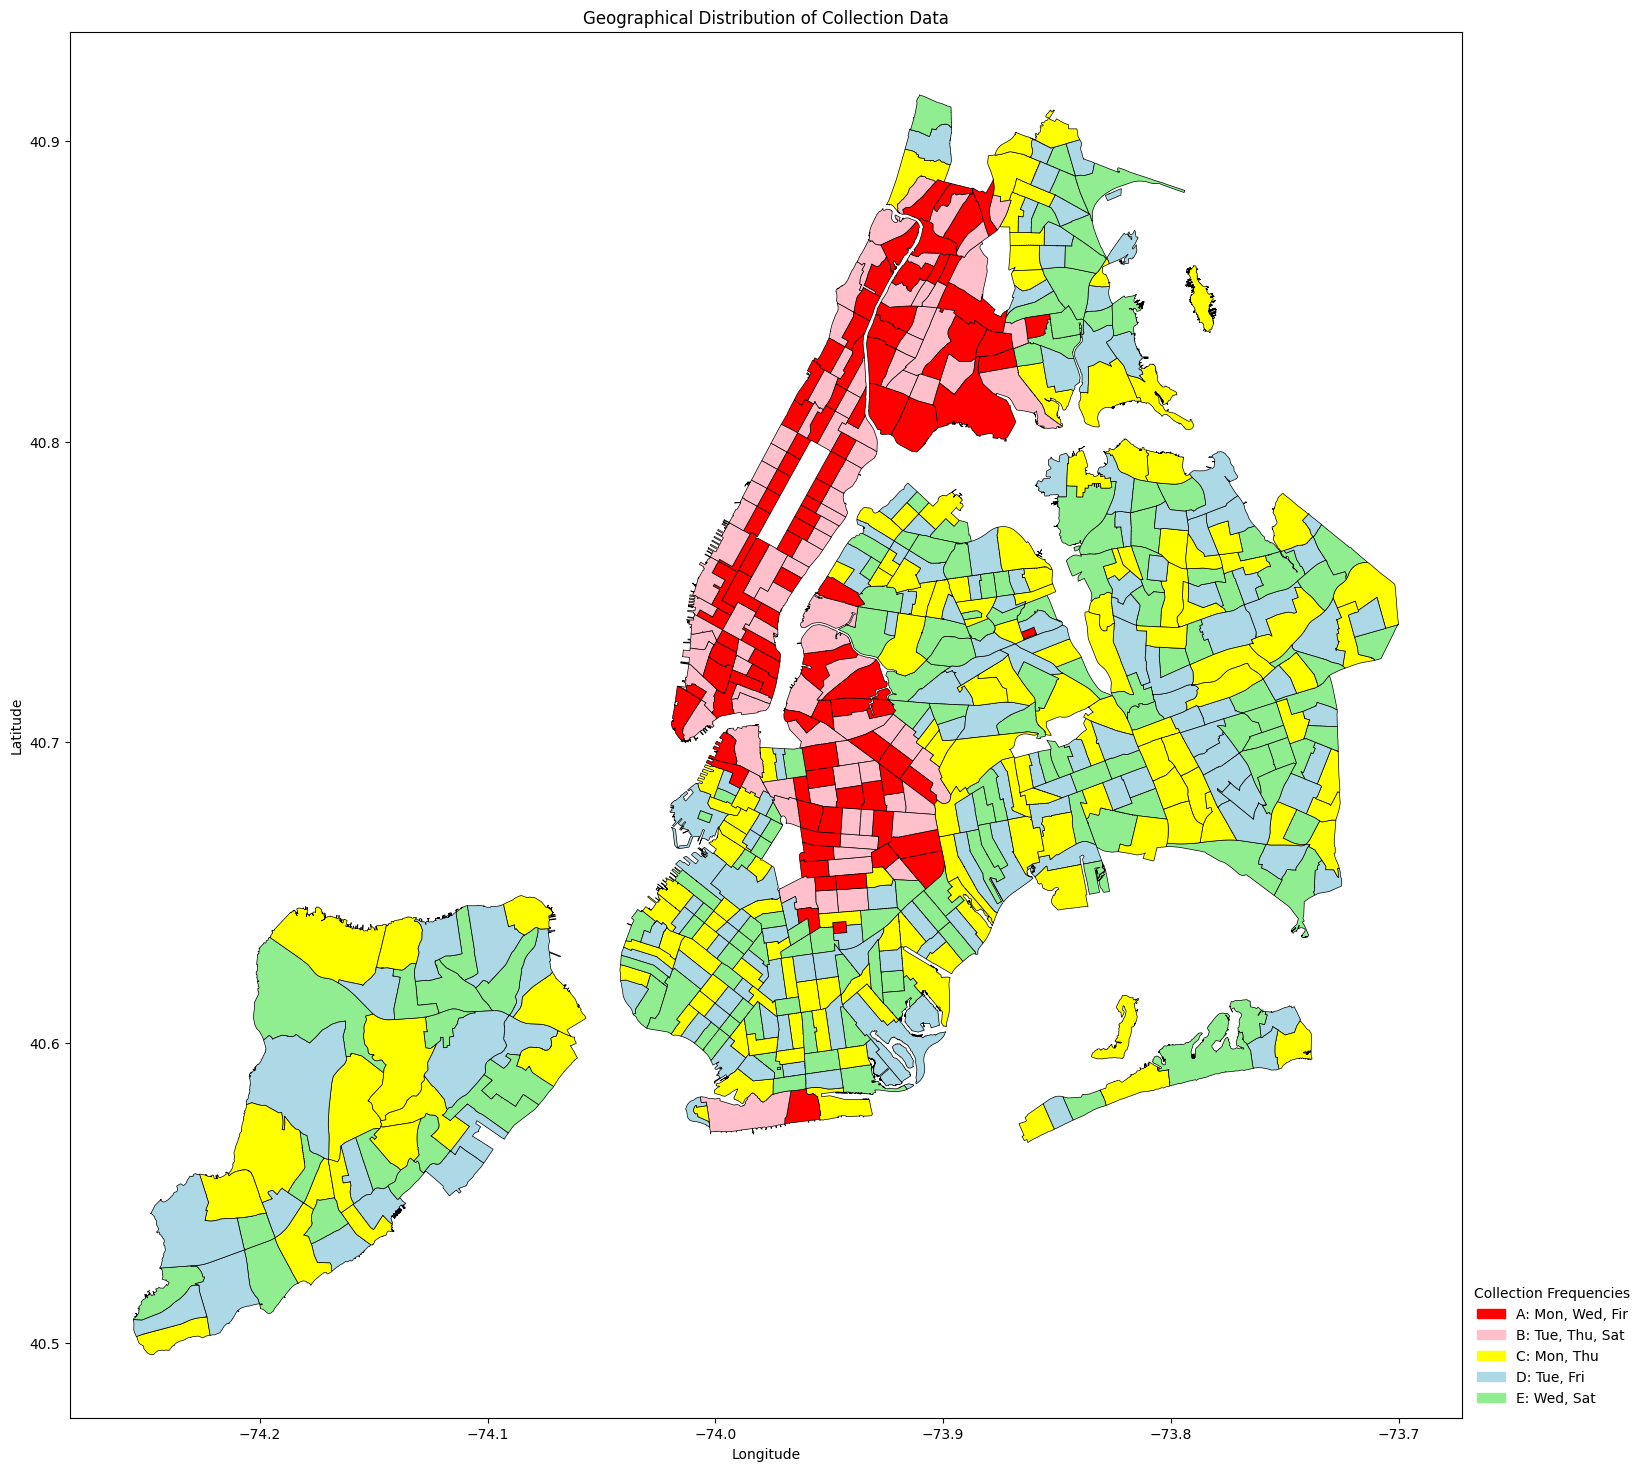

In [18]:
# Map the frequency codes to colors
frequency_colors = {
    'A': 'red',   
    'B': 'pink',  
    'C': 'yellow',    
    'D': 'lightblue', 
    'E': 'lightgreen' 
}

frequency_labels = {
    'A': 'Mon, Wed, Fir',   
    'B': 'Tue, Thu, Sat',  
    'C': 'Mon, Thu',    
    'D': 'Tue, Fri', 
    'E': 'Wed, Sat' 
}
Freq_colors = df_Freq['FREQUENCY'].map(frequency_colors)
Freq_labels = df_Freq['FREQUENCY'].map(frequency_labels)

fig, ax = plt.subplots(1, 1, figsize=(18, 18))
gdf_Freq.plot(ax=ax, color=Freq_colors,
             edgecolor='black', linewidth=0.5)
# Create a list of patches for the legend, using the frequency_labels for the descriptions
legend_patches = [Patch(color=frequency_colors[freq], label=f"{freq}: {desc}") 
                  for freq, desc in frequency_labels.items()]

# Add the legend to the plot with the custom patches
ax.legend(handles=legend_patches, title='Collection Frequencies', loc='lower left', 
          bbox_to_anchor=(1, 0), frameon=False)

ax.set_title('Geographical Distribution of Collection Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18, 18))
district_gdf_Freq.plot(ax=ax, color='lightgrey',
             edgecolor='white', linewidth=0.5)

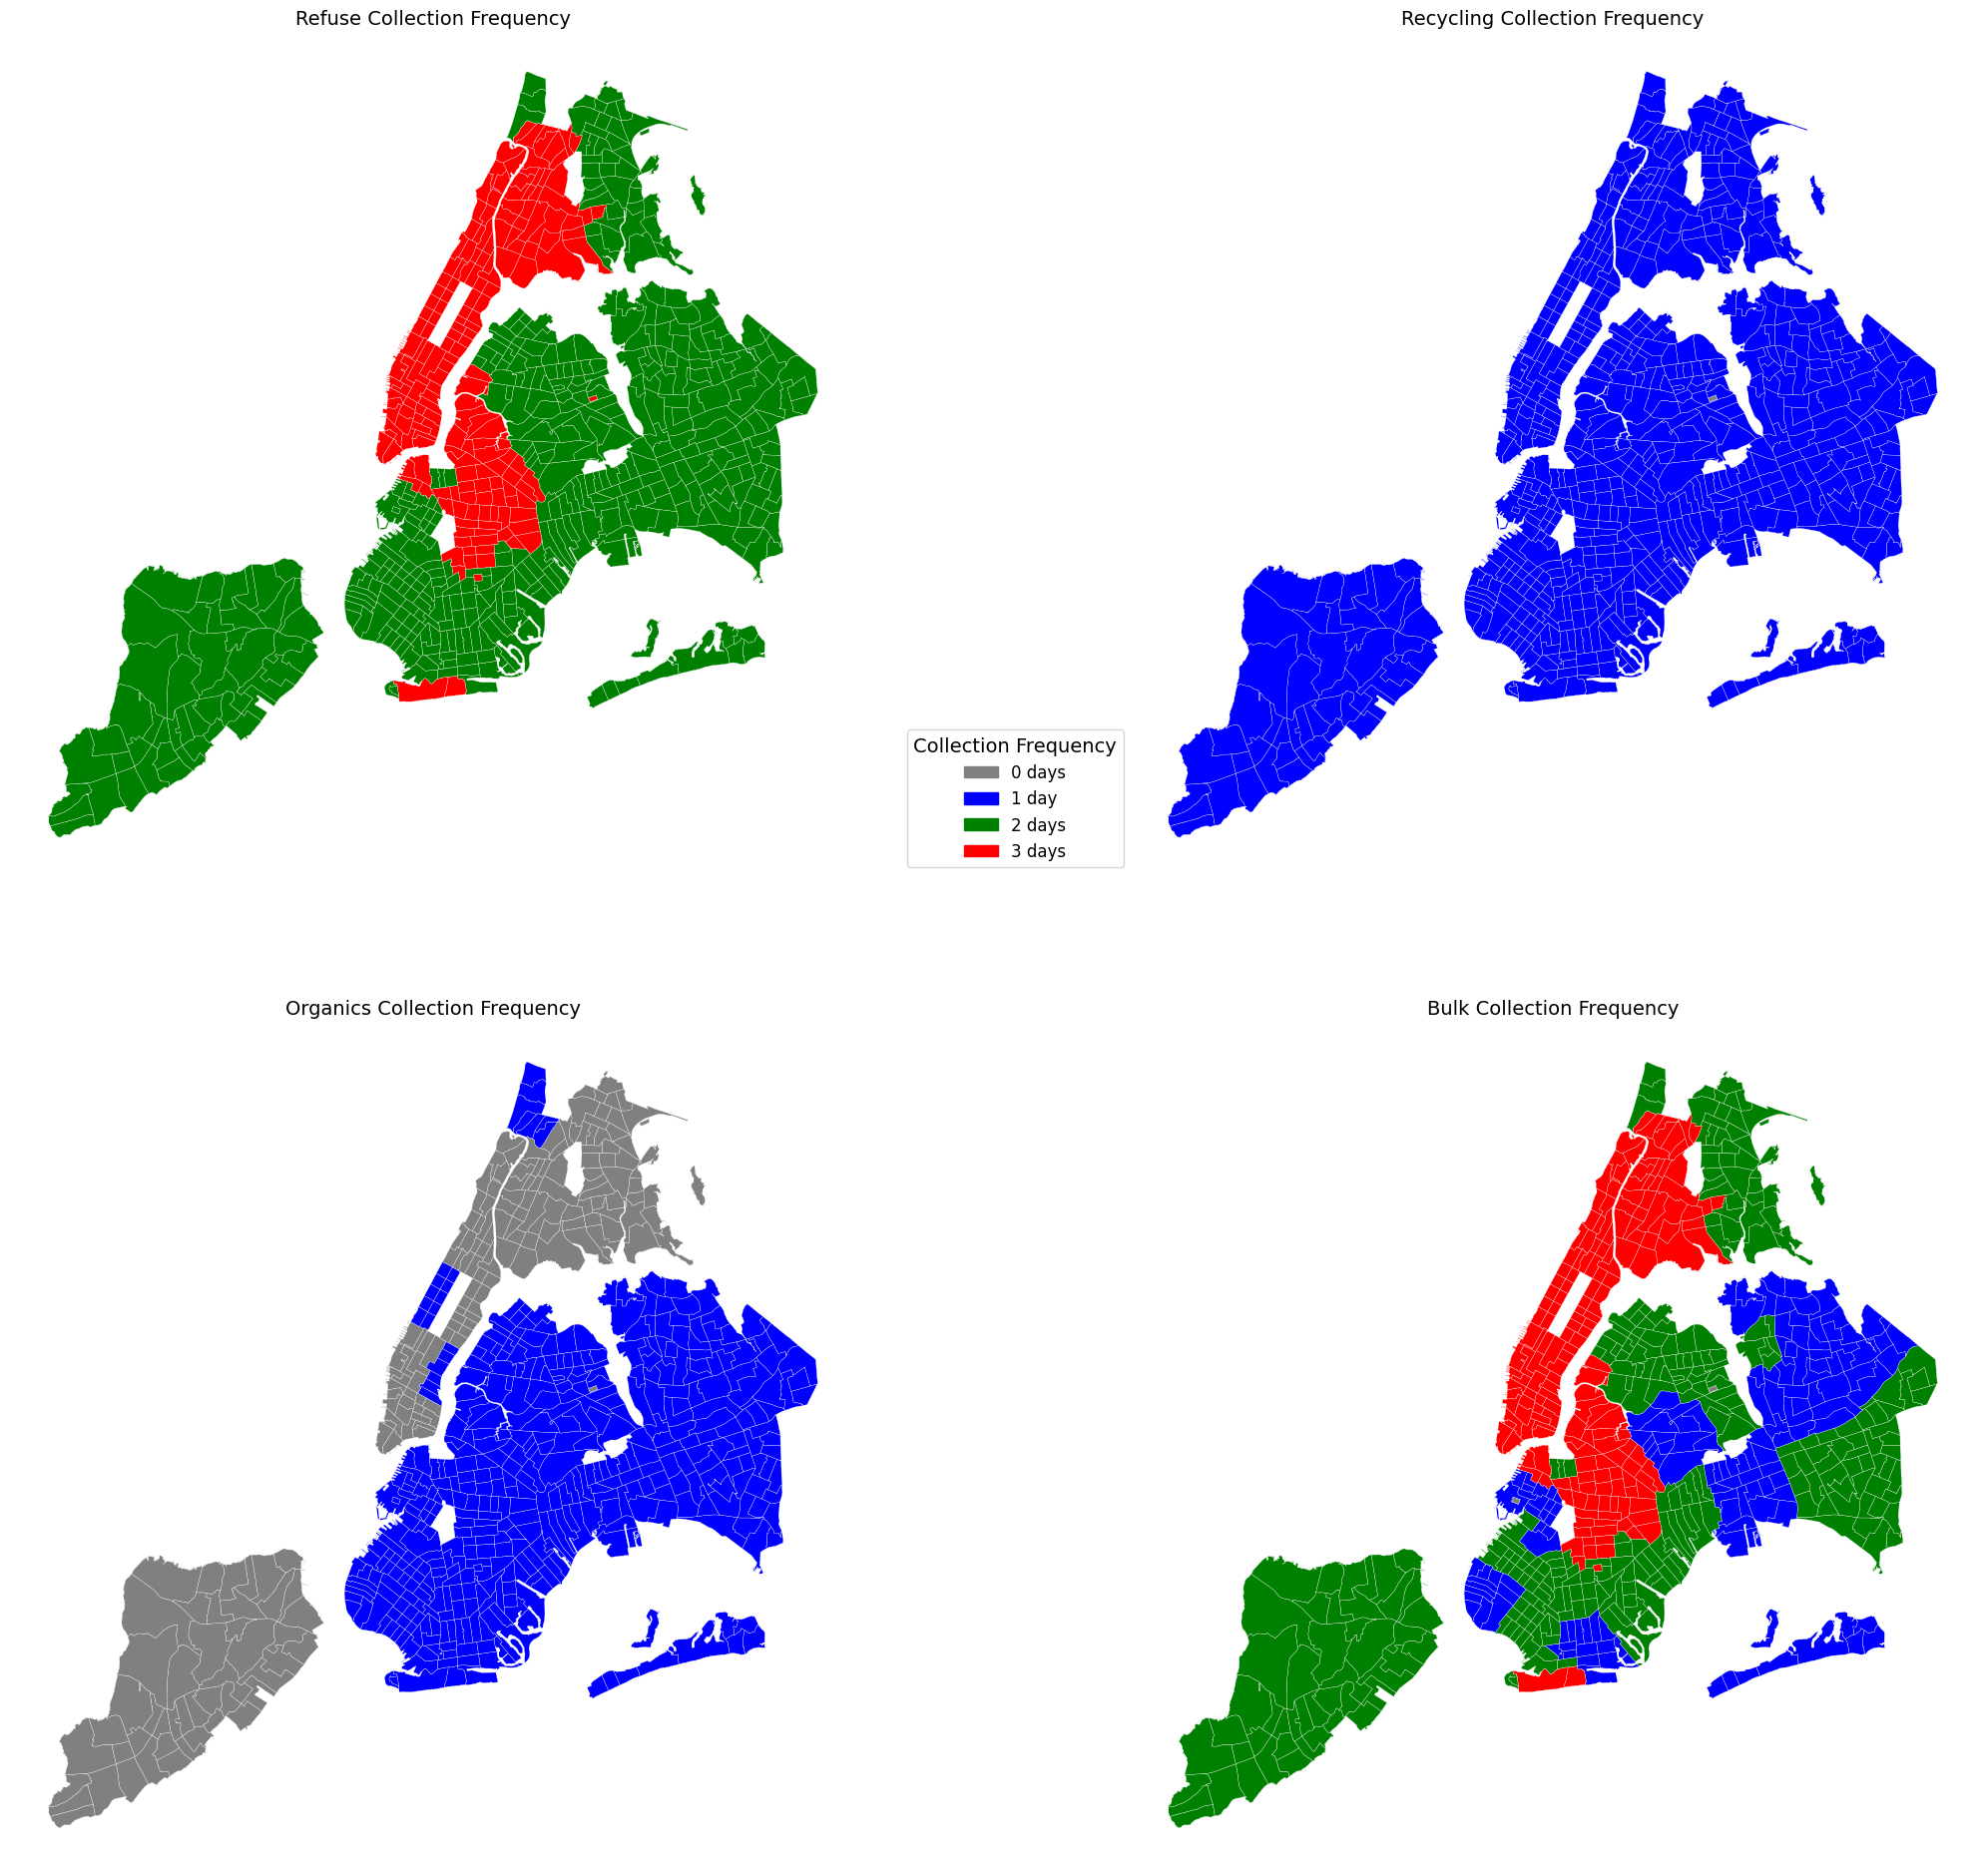

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Assuming 'gdf' is a GeoDataFrame that has already been created from 'df_Freq' with geometry defined

# Define a common colormap for all count columns
common_cmap = ListedColormap(['grey', 'blue', 'green', 'red'])

# Create patches for the legend
legend_patches = [
    Patch(color='grey', label='0 days'),
    Patch(color='blue', label='1 day'),
    Patch(color='green', label='2 days'),
    Patch(color='red', label='3 days')
]

# Create a figure with 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot each map with the common colormap
maps = ['Count_FREQ_REFUSE', 'Count_FREQ_RECYCLING', 
        'Count_FREQ_ORGANICS', 'Count_FREQ_BULK']
for i, ax in enumerate(axs.flatten()):
    column = maps[i]
    data = gdf_Freq[column]
    # Normalize data to range [0, 3]
    vmin, vmax = 0, 3
    gdf_Freq.plot(column=column, ax=ax, cmap=common_cmap, vmin=vmin, vmax=vmax, legend=False,
                 edgecolor='white', linewidth=0.2)
    ax.set_title(f'{column.split("_")[2].capitalize()} Collection Frequency',
                 fontsize=14)
    ax.axis('off')

# Place the legend on the first subplot for consistency
axs[0, 0].legend(handles=legend_patches, title='Collection Frequency',
                 loc='lower left', bbox_to_anchor=(1.05, 0),
                fontsize=12, title_fontsize=14)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()


In [20]:
district_gdf_Freq = gdf_Freq.dissolve(by='DISTRICT', as_index=False)

In [21]:
district_gdf_Freq

DISTRICT                                           geometry SECTION  \
0     BKN01  POLYGON ((-73.94197 40.70066, -73.94198 40.700...  BKN012   
1     BKN02  POLYGON ((-73.95986 40.68815, -73.95971 40.687...  BKN024   
2     BKN03  POLYGON ((-73.91718 40.68318, -73.91717 40.683...  BKN032   
3     BKN04  POLYGON ((-73.90267 40.68052, -73.90267 40.680...  BKN041   
4     BKN05  POLYGON ((-73.87655 40.64264, -73.87683 40.642...  BKN051   
5     BKN08  POLYGON ((-73.93007 40.67740, -73.92993 40.677...  BKN082   
6     BKN09  POLYGON ((-73.95023 40.65536, -73.95030 40.655...  BKN091   
7     BKN16  POLYGON ((-73.90871 40.65215, -73.90873 40.652...  BKN162   
8     BKN17  POLYGON ((-73.93610 40.63296, -73.93641 40.632...  BKN172   
9     BKS06  POLYGON ((-73.98467 40.66338, -73.98471 40.663...  BKS064   
10    BKS07  POLYGON ((-74.00492 40.63986, -74.00494 40.639...  BKS073   
11    BKS10  POLYGON ((-74.03621 40.60960, -74.03630 40.609...  BKS103   
12    BKS11  POLYGON ((-73.99170 40.59024, -73.99172 40.590...  BKS115   
13    BKS12  POLYGON ((-73.98133 40.61753, -73.98134 40.617...  BKS121   
14    BKS13  POLYGON ((-74.00484 40.58185, -74.00398 40.581...  BKS132   
15    BKS14  POLYGON ((-73.96440 40.62005, -73.96441 40.620...  BKS142   
16    BKS15  POLYGON ((-73.96067 40.58950, -73.96067 40.589...  BKS152   
17    BKS18  MULTIPOLYGON (((-73.91491 40.58626, -73.91488 ...  BKS183   
18     BX01  POLYGON ((-73.90252 40.80446, -73.90276 40.804...   BX012   
19     BX02  POLYGON ((-73.88391 40.82798, -73.88427 40.827...   BX021   
20     BX03  POLYGON ((-73.88864 40.83908, -73.88869 40.839...   BX031   
21     BX04  POLYGON ((-73.91363 40.82692, -73.91388 40.826...   BX041   
22     BX05  POLYGON ((-73.89839 40.85187, -73.89842 40.851...   BX053   
23     BX06  POLYGON ((-73.88256 40.84857, -73.88256 40.848...   BX062   
24     BX07  POLYGON ((-73.90117 40.86264, -73.90136 40.862...   BX072   
25     BX08  POLYGON ((-73.88949 40.88085, -73.88969 40.880...   BX082   
26     BX09  POLYGON ((-73.84825 40.80490, -73.84840 40.804...   BX093   
27     BX10  MULTIPOLYGON (((-73.81334 40.81337, -73.81347 ...   BX103   
28     BX11  POLYGON ((-73.84629 40.84437, -73.84629 40.844...   BX111   
29     BX12  POLYGON ((-73.84866 40.87169, -73.84892 40.871...   BX124   
30     MN01  POLYGON ((-74.00134 40.70965, -74.00127 40.709...   MN011   
31     MN02  POLYGON ((-73.99228 40.72506, -73.99228 40.725...   MN022   
32     MN03  POLYGON ((-73.97612 40.71246, -73.97617 40.712...   MN031   
33     MN04  POLYGON ((-73.99373 40.74162, -73.99382 40.741...   MN043   
34     MN05  POLYGON ((-73.98246 40.74265, -73.98272 40.742...   MN052   
35     MN06  POLYGON ((-73.97363 40.73211, -73.97361 40.732...   MN061   
36     MN07  POLYGON ((-73.97593 40.77608, -73.97595 40.776...   MN075   
37     MN08  POLYGON ((-73.95405 40.76260, -73.95406 40.762...   MN083   
38     MN09  POLYGON ((-73.95282 40.81045, -73.95308 40.810...   MN093   
39     MN10  POLYGON ((-73.94177 40.80709, -73.94195 40.806...   MN103   
40     MN11  POLYGON ((-73.93632 40.79043, -73.93669 40.789...   MN111   
41     MN12  POLYGON ((-73.93280 40.83912, -73.93294 40.838...   MN124   
42     QE07  MULTIPOLYGON (((-73.82520 40.74204, -73.82520 ...   QE072   
43     QE08  POLYGON ((-73.80659 40.70663, -73.80849 40.706...   QE083   
44     QE10  POLYGON ((-73.83845 40.65581, -73.83806 40.654...   QE102   
45     QE11  POLYGON ((-73.77723 40.74311, -73.77806 40.742...   QE113   
46     QE12  POLYGON ((-73.79003 40.66633, -73.79143 40.666...   QE121   
47     QE13  POLYGON ((-73.73723 40.64891, -73.73904 40.648...   QE132   
48     QE14  MULTIPOLYGON (((-73.85168 40.57097, -73.85177 ...   QE141   
49     QW01  POLYGON ((-73.92464 40.75225, -73.92464 40.752...   QW012   
50     QW02  POLYGON ((-73.90716 40.72742, -73.90717 40.727...   QW022   
51     QW03  POLYGON ((-73.88868 40.74713, -73.88957 40.747...   QW033   
52     QW04  POLYGON ((-73.86492 40.73387, -73.86508 40.733...   QW043   
53     

In [22]:
district_gdf_Freq.head()

DISTRICT                                           geometry SECTION  \
0    BKN01  POLYGON ((-73.94197 40.70066, -73.94198 40.700...  BKN012   
1    BKN02  POLYGON ((-73.95986 40.68815, -73.95971 40.687...  BKN024   
2    BKN03  POLYGON ((-73.91718 40.68318, -73.91717 40.683...  BKN032   
3    BKN04  POLYGON ((-73.90267 40.68052, -73.90267 40.680...  BKN041   
4    BKN05  POLYGON ((-73.87655 40.64264, -73.87683 40.642...  BKN051   

  FREQUENCY SCHEDULECODE    FREQ_REFUSE FREQ_RECYCLING FREQ_ORGANICS  \
0         B        3012B  Tue, Thu, Sat            Thu           Thu   
1         C        3024C       Mon, Thu            Thu           Thu   
2         B        3032B  Tue, Thu, Sat            Tue           Tue   
3         B        3041B  Tue, Thu, Sat            Tue           Tue   
4         E        3051E       Wed, Sat            Wed           Wed   

       FREQ_BULK  ObjectID  ...  SHAPE_Length  \
0  Tue, Thu, Sat       161  ...  18943.619157   
1       Mon, Thu       174  ...  13754.130867   
2  Tue, Thu, Sat       180  ...  11325.838020   
3  Tue, Thu, Sat       188  ...  11524.156089   
4       Wed, Sat       195  ...  13470.744483   

                                        multipolygon FREQ_RESFUSEID   Borough  \
0  MULTIPOLYGON (((-73.9543390413 40.7140717022, ...      BKN012THS  Brooklyn   
1  MULTIPOLYGON (((-73.9747866386 40.6980048114, ...       BKN024MH  Brooklyn   
2  MULTIPOLYGON (((-73.9473105666 40.6858454855, ...      BKN032THS  Brooklyn   
3  MULTIPOLYGON (((-73.9218918474 40.7093960964, ...      BKN041THS  Brooklyn   
4  MULTIPOLYGON (((-73.8847034837 40.6722342021, ...       BKN051WS  Brooklyn   

  Extracted_District Extracted_Section Count_FREQ_REFUSE  \
0                 01                 2                 3   
1                 02                 4                 2   
2                 03                 2                 3   
3                 04                 1                 3   
4                 05                 1                 2   

   Count_FREQ_RECYCLING  Count_FREQ_ORGANICS  Count_FREQ_BULK  
0                     1                    1                3  
1                     1                    1                2  
2                     1                    1                3  
3                     1                    1                3  
4                     1                    1                2  

[5 rows x 21 columns]

In [23]:
district_gdf_Freq.columns

Index(['DISTRICT', 'geometry', 'SECTION', 'FREQUENCY', 'SCHEDULECODE',
       'FREQ_REFUSE', 'FREQ_RECYCLING', 'FREQ_ORGANICS', 'FREQ_BULK',
       'ObjectID', 'SHAPE_Area', 'SHAPE_Length', 'multipolygon',
       'FREQ_RESFUSEID', 'Borough', 'Extracted_District', 'Extracted_Section',
       'Count_FREQ_REFUSE', 'Count_FREQ_RECYCLING', 'Count_FREQ_ORGANICS',
       'Count_FREQ_BULK'],
      dtype='object')

### Litter Basket

BASKETTYPE:
- Physical type of basket. 
- C = Solar-powered Compactor, D = Parks basket, E = Seasonal Wire basket, H = High-end basket, R = PSR (Public Space Receptacle), S = Wire basket. 

OwnerType:
- "Ownership of basket. 
- D = DSNY-owned, B = BID-owned, O = Other, P = Privately owned.

In [24]:
df_lb = pd.read_csv('DSNY_Litter_Basket_Inventory_20240412.csv')
df_lb.head()

BASKETID BASKETTYPE DIRECTION                  LOCATION_DESCRIPTION  \
0  20830076          S       NaN                                   NaN   
1  10930211          S       NaN                                   NaN   
2  10720061          H        SW  SW corner of COLUMBUS AV and W 80 ST   
3  10630050          H        NE         NE corner of 3 AV and E 52 ST   
4  10110042          H       NaN                                   NaN   

  OWNERTYPE SECTION  STATEPLANE_LABELX  STATEPLANE_LABELY  \
0         D   BX083       1.010882e+06      262449.998772   
1         D   MN093       9.984087e+05      243063.759985   
2         B   MN072       9.911033e+05      224397.890165   
3         B   MN063       9.926869e+05      215111.260444   
4         P   MN011       9.797356e+05      198413.844692   

   STATEPLANE_SNAPPEDX  STATEPLANE_SNAPPEDY  STREETNAME1 STREETNAME2  \
0                  NaN                  NaN          NaN         NaN   
1                  NaN                  NaN          NaN         NaN   
2        991140.107271        224403.488251  COLUMBUS AV     W 80 ST   
3        992645.432672        215099.392358         3 AV     E 52 ST   
4                  NaN                  NaN          NaN         NaN   

   OBJECTID                                 point  
0      9118  POINT (-73.9036821612 40.8869984052)  
1      7285  POINT (-73.9488347059 40.8338178525)  
2      5689  POINT (-73.9752530707 40.7825938981)  
3      5285  POINT (-73.9695467272 40.7571031488)  
4      4666  POINT (-74.0162835878 40.7112757283)

In [25]:
df_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24681 entries, 0 to 24680
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BASKETID              24681 non-null  int64  
 1   BASKETTYPE            24681 non-null  object 
 2   DIRECTION             24418 non-null  object 
 3   LOCATION_DESCRIPTION  24605 non-null  object 
 4   OWNERTYPE             24681 non-null  object 
 5   SECTION               24681 non-null  object 
 6   STATEPLANE_LABELX     24665 non-null  float64
 7   STATEPLANE_LABELY     24665 non-null  float64
 8   STATEPLANE_SNAPPEDX   24596 non-null  float64
 9   STATEPLANE_SNAPPEDY   24596 non-null  float64
 10  STREETNAME1           24551 non-null  object 
 11  STREETNAME2           22010 non-null  object 
 12  OBJECTID              24681 non-null  int64  
 13  point                 24681 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 2.6+ MB


In [26]:
df_lb['point']

0        POINT (-73.9036821612 40.8869984052)
1        POINT (-73.9488347059 40.8338178525)
2        POINT (-73.9752530707 40.7825938981)
3        POINT (-73.9695467272 40.7571031488)
4        POINT (-74.0162835878 40.7112757283)
                         ...                 
24676    POINT (-73.9821672873 40.7657333716)
24677    POINT (-73.9254231745 40.7616210934)
24678    POINT (-73.9281489108 40.8566075654)
24679    POINT (-73.9350525017 40.7771402386)
24680    POINT (-73.9630073077 40.7748186055)
Name: point, Length: 24681, dtype: object

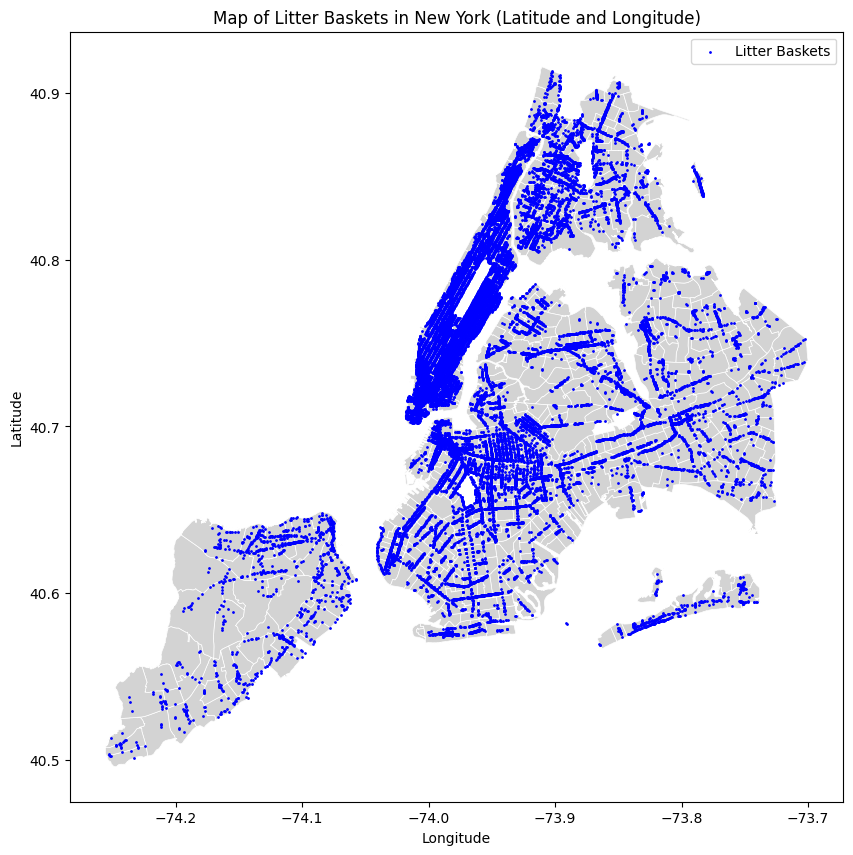

In [27]:
df_lb = pd.read_csv('DSNY_Litter_Basket_Inventory_20240412.csv')
# Convert the 'point' string to a geometric object using the WKT format
df_lb['geometry'] = df_lb['point'].apply(wkt.loads)

# Create a GeoDataFrame using the geometry column with WGS 84 CRS (EPSG:4326)
gdf_lb = gpd.GeoDataFrame(df_lb, crs="EPSG:4326", geometry='geometry')

# Plotting the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_Freq.plot(ax=ax, color='lightgrey',
             edgecolor='white', linewidth=0.5)
gdf_lb.plot(ax=ax, markersize=1, color='blue', label='Litter Baskets')

# Setting the title and labels
plt.title('Map of Litter Baskets in New York (Latitude and Longitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [28]:
df_lb['BASKETTYPE'].value_counts(normalize=True,ascending=False)*100

BASKETTYPE
S    47.222560
R    23.451238
H    19.760139
D     5.903326
C     3.573599
E     0.089137
Name: proportion, dtype: float64

In [29]:
df_lb['OWNERTYPE'].value_counts(normalize=True,ascending=False)*100

OWNERTYPE
D    74.206880
B    14.509137
O     9.493132
P     1.790851
Name: proportion, dtype: float64

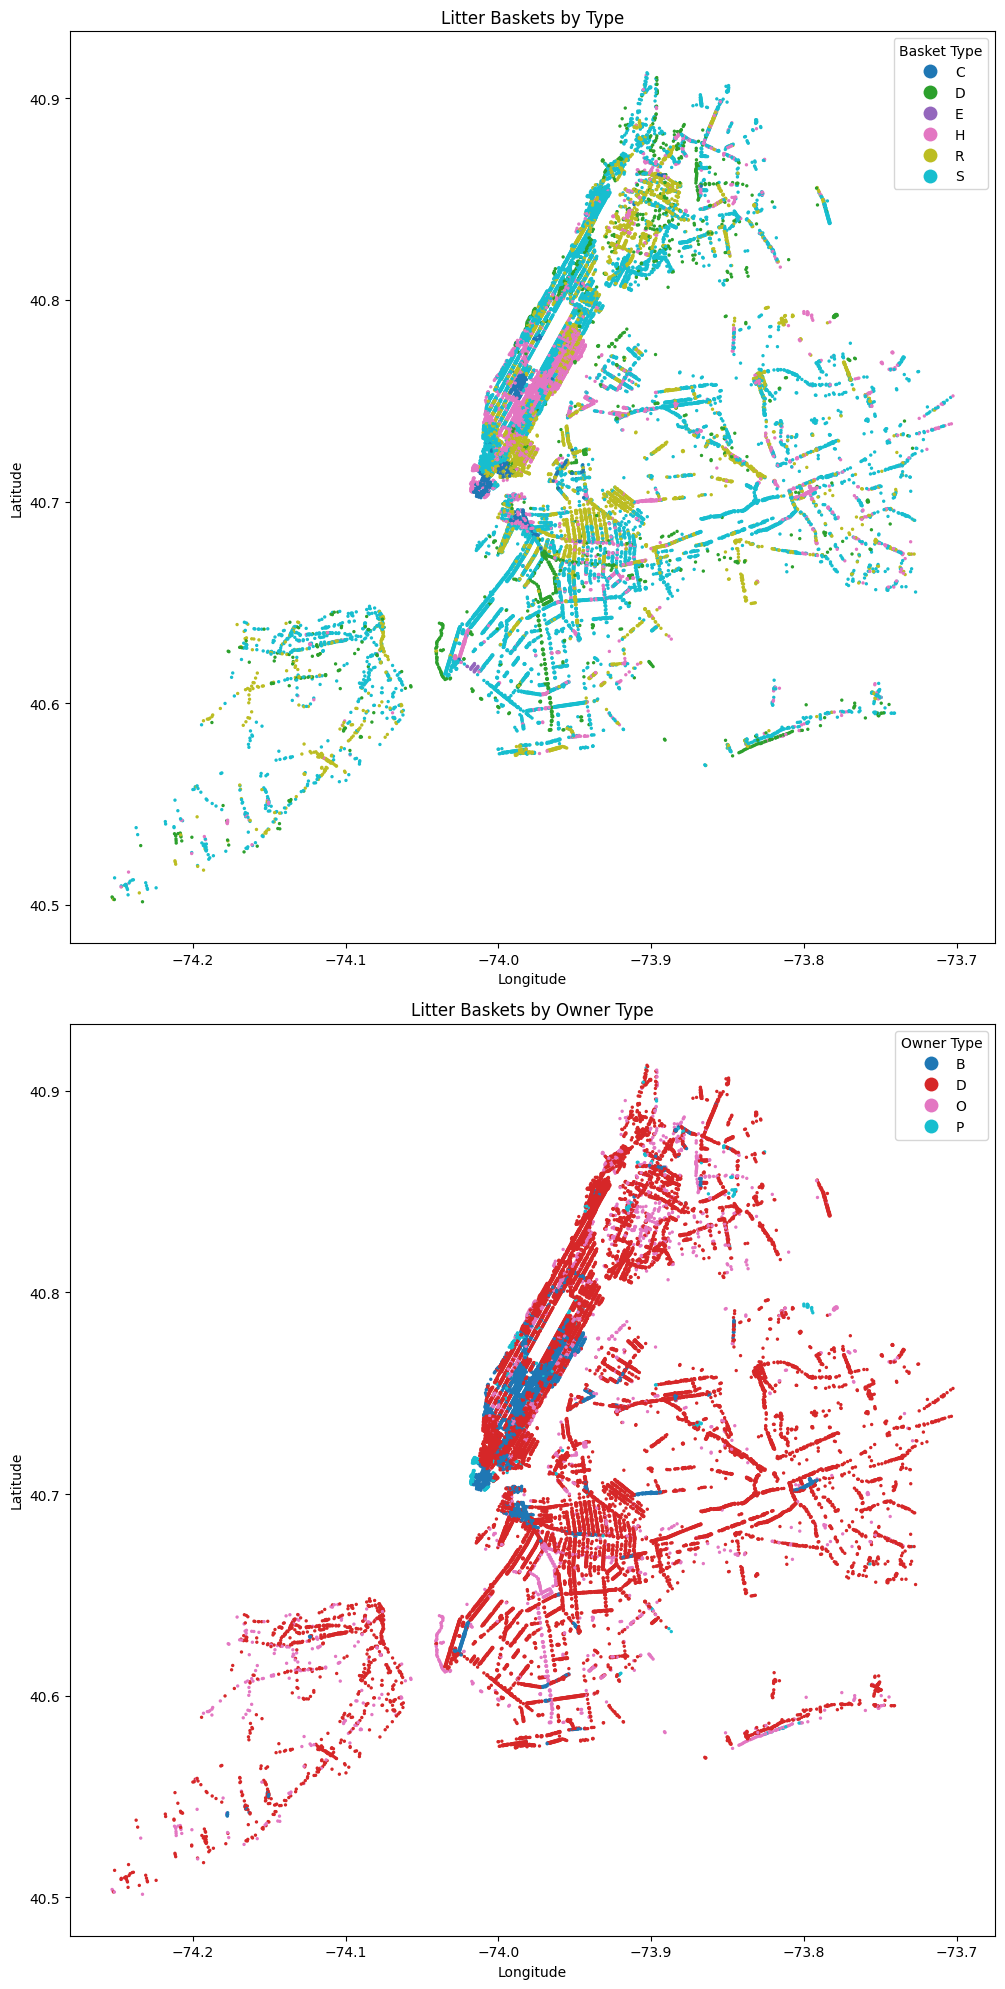

In [30]:
# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))

# First map: color by BASKETTYPE
gdf_lb.plot(ax=ax1, column='BASKETTYPE', legend=True,
                        legend_kwds={'title': 'Basket Type'},markersize=2)
ax1.set_title('Litter Baskets by Type')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Second map: color by OWNERTYPE
gdf_lb.plot(ax=ax2, column='OWNERTYPE', legend=True,
                        legend_kwds={'title': 'Owner Type'},markersize=2)
ax2.set_title('Litter Baskets by Owner Type')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

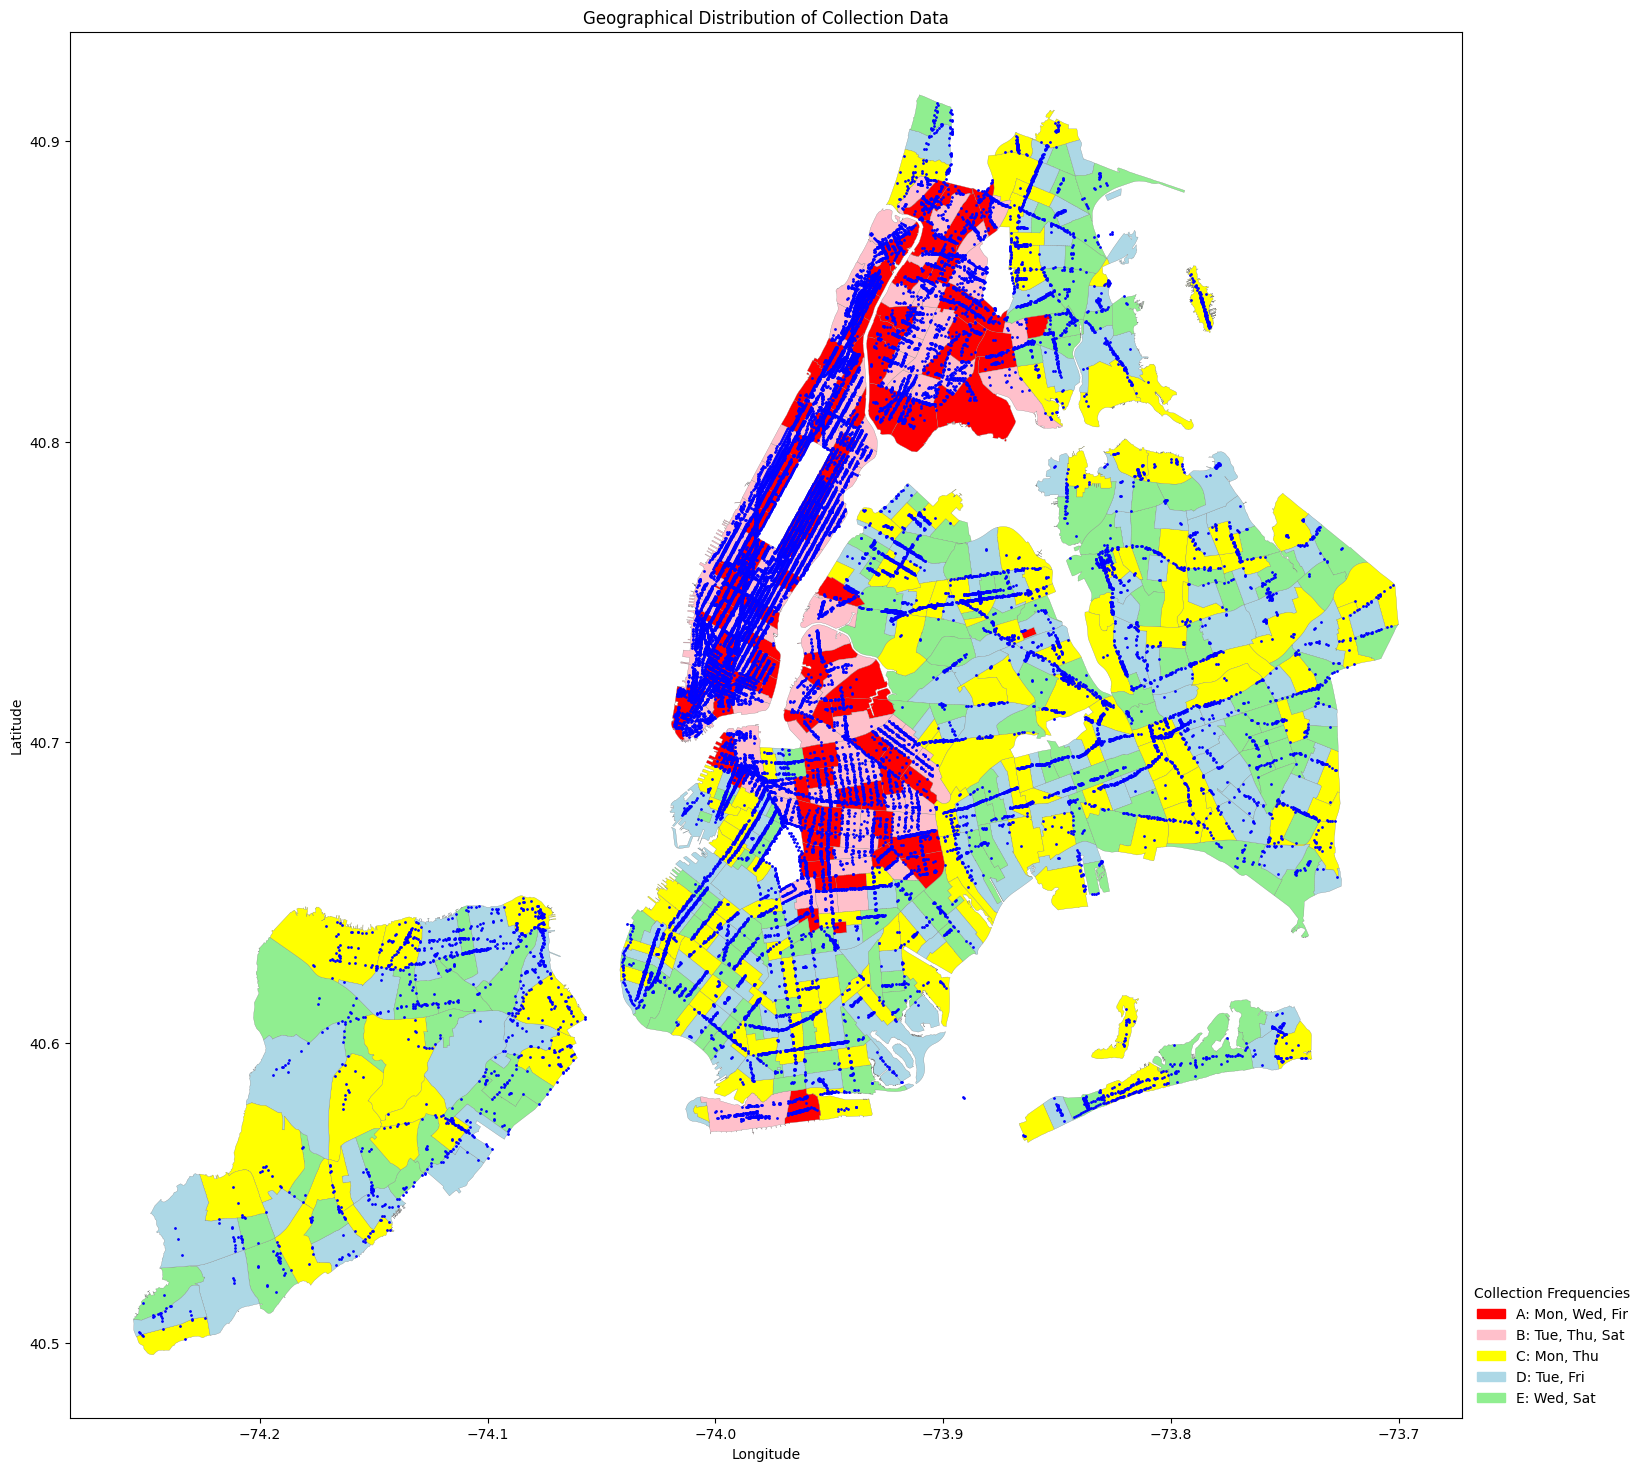

In [31]:
# Over lapping 
fig, ax = plt.subplots(1, 1, figsize=(18, 18))

gdf_Freq.plot(ax=ax, color=Freq_colors,
             edgecolor='grey', linewidth=0.2)

gdf_lb.plot(ax=ax, markersize=1, color='blue', label='Litter Baskets')

# Create a list of patches for the legend, using the frequency_labels for the descriptions
legend_patches = [Patch(color=frequency_colors[freq], label=f"{freq}: {desc}") 
                  for freq, desc in frequency_labels.items()]
# Add the legend to the plot with the custom patches
ax.legend(handles=legend_patches, title='Collection Frequencies', loc='lower left', 
          bbox_to_anchor=(1, 0), frameon=False)
ax.set_title('Geographical Distribution of Collection Data')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [32]:
# Perform the spatial join, replace 'op' with 'predicate' due to deprecation warning
joined_gdf = gpd.sjoin(gdf_lb, gdf_Freq, how='inner', predicate='within')

# Count the number of points in each polygon
point_count = joined_gdf.groupby('index_right').size()

# Convert the Series to a DataFrame
point_count_df = point_count.reset_index(name='point_count')

# Merge the point count back into the original polygon GeoDataFrame
# The merge should be on the index of gdf_Freq, which should align with 'index_right' from the spatial join
# Since the index of gdf_Freq is unnamed, we should merge on the index without specifying a name
gdf_Freq_with_count = gdf_Freq.merge(point_count_df, how='left', left_index=True, right_on='index_right')

# Now, if you print gdf_Freq_with_count, it will have a new column 'point_count' with the number of points in each polygon
gdf_Freq_with_count[['geometry', 'point_count']].head()

geometry  point_count
0.0  MULTIPOLYGON (((-73.84289 40.57420, -73.84340 ...         70.0
1.0  MULTIPOLYGON (((-73.88470 40.67223, -73.88476 ...         25.0
2.0  MULTIPOLYGON (((-73.79237 40.75302, -73.79229 ...          9.0
3.0  MULTIPOLYGON (((-73.99826 40.63601, -73.99839 ...         27.0
4.0  MULTIPOLYGON (((-73.85425 40.85383, -73.85422 ...         39.0

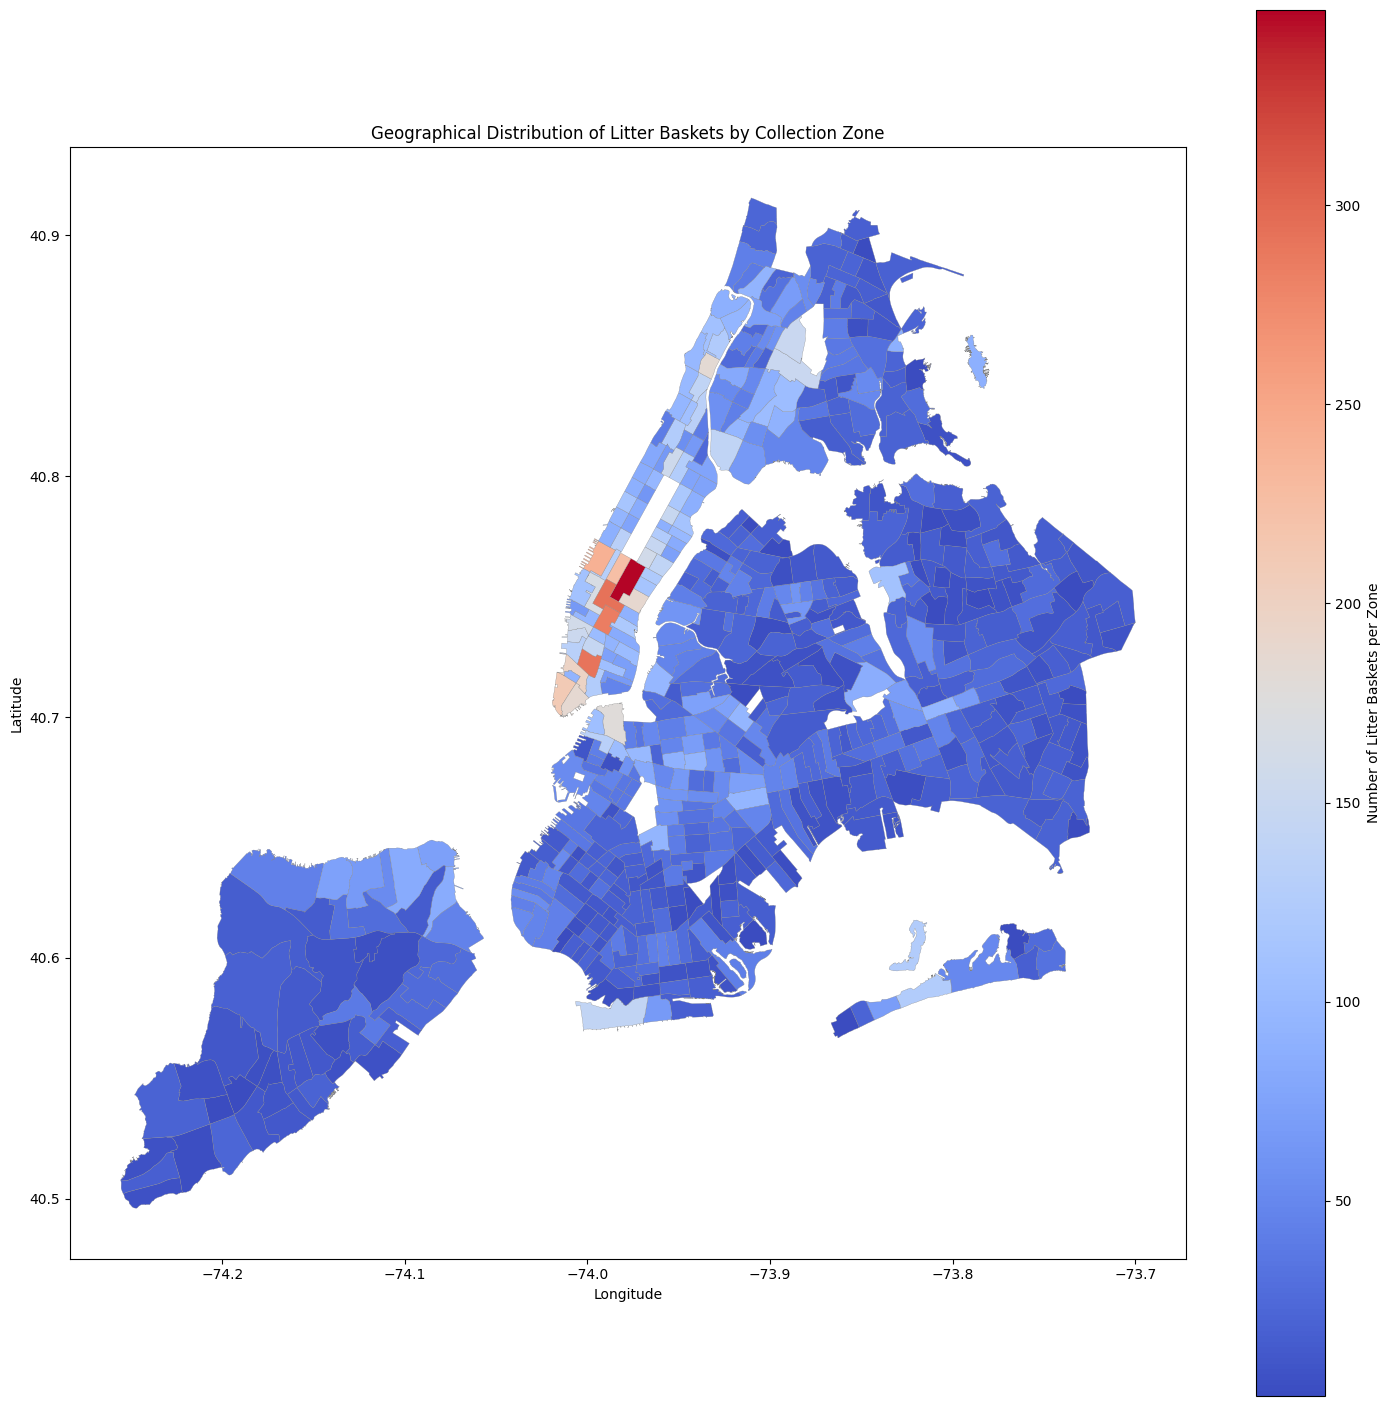

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))

# Plot the polygons and use the 'point_count' column to determine the color
gdf_Freq_with_count.plot(ax=ax, column='point_count', cmap='coolwarm', legend=True,
                         legend_kwds={'label': "Number of Litter Baskets per Zone"},
                        edgecolor='grey', linewidth=0.2)

# Add other plot customizations here
ax.set_title('Geographical Distribution of Litter Baskets by Collection Zone')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


In [34]:
# Perform the spatial join, replace 'op' with 'predicate' due to deprecation warning
joined_gdf = gpd.sjoin(gdf_lb, district_gdf_Freq, how='inner', predicate='within')

# Count the number of points in each polygon
point_count = joined_gdf.groupby('index_right').size()

# Convert the Series to a DataFrame
point_count_df = point_count.reset_index(name='point_count')

# Merge the point count back into the original polygon GeoDataFrame
# The merge should be on the index of gdf_Freq, which should align with 'index_right' from the spatial join
# Since the index of gdf_Freq is unnamed, we should merge on the index without specifying a name
gdf_Freq_with_count = district_gdf_Freq.merge(point_count_df, how='left', left_index=True, right_on='index_right')

# Now, if you print gdf_Freq_with_count, it will have a new column 'point_count' with the number of points in each polygon
gdf_Freq_with_count[['geometry', 'point_count']].head()


geometry  point_count
0  POLYGON ((-73.94197 40.70066, -73.94198 40.700...          438
1  POLYGON ((-73.95986 40.68815, -73.95971 40.687...          769
2  POLYGON ((-73.91718 40.68318, -73.91717 40.683...          570
3  POLYGON ((-73.90267 40.68052, -73.90267 40.680...          320
4  POLYGON ((-73.87655 40.64264, -73.87683 40.642...          308

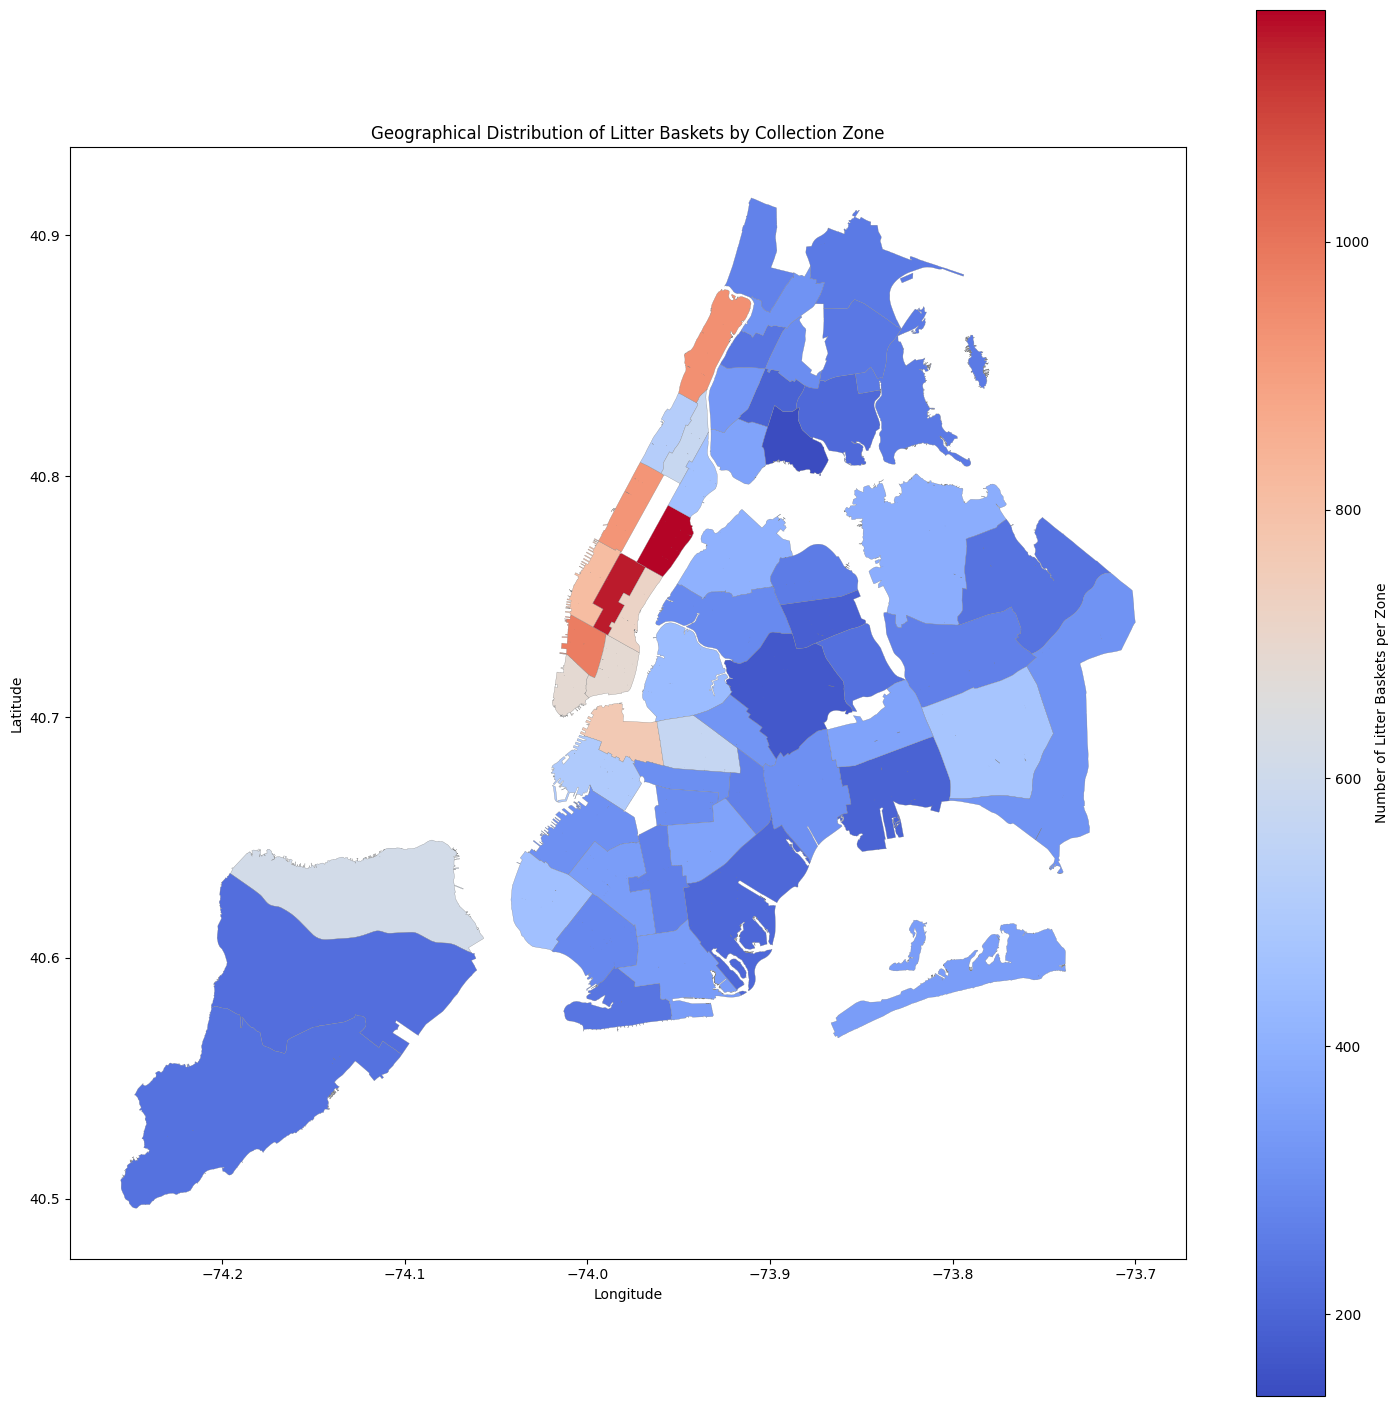

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))

# Plot the polygons and use the 'point_count' column to determine the color
gdf_Freq_with_count.plot(ax=ax, column='point_count', cmap='coolwarm', legend=True,
                         legend_kwds={'label': "Number of Litter Baskets per Zone"},
                        edgecolor='grey', linewidth=0.2)

# Add other plot customizations here
ax.set_title('Geographical Distribution of Litter Baskets by Collection Zone')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


### DSNY_Monthly_Tonnage

REFUSETONSCOLLECTED:
- Tons of trash or refuse collected from NYC residences and institutions serviced by the NYC Department of Sanitation.

PAPERTONSCOLLECTED:
- Tons of source-separated recyclable paper collected from NYC residences and institutions serviced by the NYC Department of Sanitation.

MGPTONSCOLLECTED:
- Tons of source-separated recyclable metal, glass, plastic, and beverage cartons collected from NYC residences and institutions serviced by the NYC Department of Sanitation.!

BOROUGH_ID:
- 1 = Manhattan; 2 = Bronx; 3 = Brooklyn; 4 = Queens; 5 = Staten Island

In [36]:
df_mt=pd.read_csv('DSNY_Monthly_Tonnage_Data_20240412.csv')

In [37]:
mask = df_mt['MONTH'].str.startswith('2023')
df_mt = df_mt[mask]
df_mt.head()

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
2834  2023 / 01   Brooklyn                09               2885.1   
2835  2023 / 01   Brooklyn                05               4385.2   
2836  2023 / 01      Bronx                11               2851.8   
2837  2023 / 01      Bronx                10               2444.5   
2838  2023 / 01  Manhattan                10               2554.2   

      PAPERTONSCOLLECTED  MGPTONSCOLLECTED  RESORGANICSTONS  \
2834               284.7             232.6              NaN   
2835               256.9             435.0              NaN   
2836               274.9             340.5              NaN   
2837               292.8             338.3              NaN   
2838               248.7             231.3              NaN   

      SCHOOLORGANICTONS  LEAVESORGANICTONS  XMASTREETONS  BOROUGH_ID  
2834                NaN                NaN          12.9         3.0  
2835                NaN                NaN           5.3         3.0  
2836                NaN                NaN          12.9         2.0  
2837               36.7                NaN          19.6         2.0  
2838                NaN                NaN          14.4         1.0

In [38]:
df_mt.isnull().sum()

MONTH                    0
BOROUGH                  0
COMMUNITYDISTRICT        0
REFUSETONSCOLLECTED      0
PAPERTONSCOLLECTED       0
MGPTONSCOLLECTED         0
RESORGANICSTONS        442
SCHOOLORGANICTONS      435
LEAVESORGANICTONS      689
XMASTREETONS           649
BOROUGH_ID               0
dtype: int64

In [39]:
columns_to_drop = ['RESORGANICSTONS', 'SCHOOLORGANICTONS', 'LEAVESORGANICTONS', 'XMASTREETONS']
df_mt = df_mt.drop(columns=columns_to_drop)

In [40]:
df_mt['TOTALTONSCOLLECTED'] = df_mt['REFUSETONSCOLLECTED'] + df_mt['PAPERTONSCOLLECTED'] + df_mt['MGPTONSCOLLECTED']

In [41]:
df_mt

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
2834   2023 / 01   Brooklyn                09               2885.1   
2835   2023 / 01   Brooklyn                05               4385.2   
2836   2023 / 01      Bronx                11               2851.8   
2837   2023 / 01      Bronx                10               2444.5   
2838   2023 / 01  Manhattan                10               2554.2   
...          ...        ...               ...                  ...   
23479  2023 / 12     Queens                07               6434.3   
23518  2023 / 10  Manhattan                06               2835.2   
23532  2023 / 12   Brooklyn                15               4447.2   
23562  2023 / 12     Queens                08               3677.0   
23574  2023 / 12     Queens                12               6542.4   

       PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  
2834                284.7             232.6         3.0              3402.4  
2835                256.9             435.0         3.0              5077.1  
2836                274.9             340.5         2.0              3467.2  
2837                292.8             338.3         2.0              3075.6  
2838                248.7             231.3         1.0              3034.2  
...                   ...               ...         ...                 ...  
23479               849.2             765.1         4.0              8048.6  
23518               484.4             337.0         1.0              3656.6  
23532               582.2             488.3         3.0              5517.7  
23562               481.5             390.1         4.0              4548.6  
23574               561.6             930.8         4.0              8034.8  

[708 rows x 8 columns]

In [42]:
df_mt_bd = df_mt.groupby(by = ['BOROUGH','COMMUNITYDISTRICT'], as_index = False).sum()

In [43]:
df_mt_bd

BOROUGH COMMUNITYDISTRICT  \
0           Bronx                01   
1           Bronx                02   
2           Bronx                03   
3           Bronx                04   
4           Bronx                05   
5           Bronx                06   
6           Bronx                07   
7           Bronx                08   
8           Bronx                09   
9           Bronx                10   
10          Bronx                11   
11          Bronx                12   
12       Brooklyn                01   
13       Brooklyn                02   
14       Brooklyn                03   
15       Brooklyn                04   
16       Brooklyn                05   
17       Brooklyn                06   
18       Brooklyn                07   
19       Brooklyn                08   
20       Brooklyn                09   
21       Brooklyn                10   
22       Brooklyn                11   
23       Brooklyn                12   
24       Brooklyn                13   
25       Brooklyn                14   
26       Brooklyn                15   
27       Brooklyn                16   
28       Brooklyn                17   
29       Brooklyn                18   
30      Manhattan                01   
31      Manhattan                02   
32      Manhattan                03   
33      Manhattan                04   
34      Manhattan                05   
35      Manhattan                06   
36      Manhattan                07   
37      Manhattan                08   
38      Manhattan                09   
39      Manhattan                10   
40      Manhattan                11   
41      Manhattan                12   
42         Queens                01   
43         Queens                02   
44         Queens                03   
45         Queens                04   
46         Queens                05   
47         Queens                06   
48         Queens                07   
49         Queens                08   
50         Queens                09   
51         Queens                10   
52         Queens                11   
53         Queens                12   
54         Queens                13   
55         Queens                14   
56  Staten Island                01   
57  Staten Island                02   
58  Staten Island                03   

                                                MONTH  REFUSETONSCOLLECTED  \
0   2023 / 072023 / 092023 / 012023 / 022023 / 042...              26229.8   
1   2023 / 042023 / 052023 / 092023 / 072023 / 122...              18027.2   
2   2023 / 082023 / 122023 / 022023 / 012023 / 102...              24901.8   
3   2023 / 022023 / 052023 / 042023 / 012023 / 032...              45923.1   
4   2023 / 022023 / 042023 / 072023 / 112023 / 032...              38932.2   
5   2023 / 122023 / 012023 / 022023 / 082023 / 032...              27131.6   
6   2023 / 092023 / 052023 / 022023 / 062023 / 072...              42167.4   
7   2023 / 112023 / 022023 / 062023 / 082023 / 032...              27135.8   
8   2023 / 022023 / 082023 / 062023 / 102023 / 012...              44179.8   
9   2023 / 012023 / 112023 / 052023 / 062023 / 102...              31398.2   
10  2023 / 012023 / 072023 / 092023 / 102023 / 052...              36606.7   
11  2023 / 022023 / 072023 / 032023 / 052023 / 122...              46505.5   
12  2023 / 022023 / 052023 / 062023 / 032023 / 082...              66587.8   
13  2023 / 052023 / 042023 / 012023 / 022023 / 072...              32289.0   
14  2023 / 012023 / 032023 / 072023 / 082023 / 022...              49724.1   
15  2023 / 052023 / 062023 / 042023 / 022023 / 112...              38219.3   
16  2023 / 012023 / 032023 / 062023 / 082023 / 022...              55366.3   
17  2023 / 012023 / 072023 / 042023 / 062023 / 032...              24958.3   
18  2023 / 012023 / 022023 / 042023 / 032023 / 072...              37167.0   
19  2023 / 072023 / 122023 / 112023 / 082023 / 032...              29715.8   
20  2023 / 012023 / 082023 / 09

In [44]:
district_gdf_Freq_mt = df_mt_bd.merge(district_gdf_Freq, 
                    left_on=['BOROUGH', 'COMMUNITYDISTRICT'], 
                    right_on=['Borough', 'Extracted_District'], how='right')

In [45]:
district_gdf_Freq_mt.columns

Index(['BOROUGH', 'COMMUNITYDISTRICT', 'MONTH', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'BOROUGH_ID',
       'TOTALTONSCOLLECTED', 'DISTRICT', 'geometry', 'SECTION', 'FREQUENCY',
       'SCHEDULECODE', 'FREQ_REFUSE', 'FREQ_RECYCLING', 'FREQ_ORGANICS',
       'FREQ_BULK', 'ObjectID', 'SHAPE_Area', 'SHAPE_Length', 'multipolygon',
       'FREQ_RESFUSEID', 'Borough', 'Extracted_District', 'Extracted_Section',
       'Count_FREQ_REFUSE', 'Count_FREQ_RECYCLING', 'Count_FREQ_ORGANICS',
       'Count_FREQ_BULK'],
      dtype='object')

In [46]:
district_gdf_Freq_mt.head()

BOROUGH COMMUNITYDISTRICT  \
0  Brooklyn                01   
1  Brooklyn                02   
2  Brooklyn                03   
3  Brooklyn                04   
4  Brooklyn                05   

                                               MONTH  REFUSETONSCOLLECTED  \
0  2023 / 022023 / 052023 / 062023 / 032023 / 082...              66587.8   
1  2023 / 052023 / 042023 / 012023 / 022023 / 072...              32289.0   
2  2023 / 012023 / 032023 / 072023 / 082023 / 022...              49724.1   
3  2023 / 052023 / 062023 / 042023 / 022023 / 112...              38219.3   
4  2023 / 012023 / 032023 / 062023 / 082023 / 022...              55366.3   

   PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  \
0              7873.0            5020.4        36.0             79481.2   
1              6065.9            4659.4        36.0             43014.3   
2              5120.4            3876.0        36.0             58720.5   
3              2920.6            4223.0        36.0             45362.9   
4              2719.9            5140.7        36.0             63226.9   

  DISTRICT                                           geometry  ...  \
0    BKN01  POLYGON ((-73.94197 40.70066, -73.94198 40.700...  ...   
1    BKN02  POLYGON ((-73.95986 40.68815, -73.95971 40.687...  ...   
2    BKN03  POLYGON ((-73.91718 40.68318, -73.91717 40.683...  ...   
3    BKN04  POLYGON ((-73.90267 40.68052, -73.90267 40.680...  ...   
4    BKN05  POLYGON ((-73.87655 40.64264, -73.87683 40.642...  ...   

   SHAPE_Length                                       multipolygon  \
0  18943.619157  MULTIPOLYGON (((-73.9543390413 40.7140717022, ...   
1  13754.130867  MULTIPOLYGON (((-73.9747866386 40.6980048114, ...   
2  11325.838020  MULTIPOLYGON (((-73.9473105666 40.6858454855, ...   
3  11524.156089  MULTIPOLYGON (((-73.9218918474 40.7093960964, ...   
4  13470.744483  MULTIPOLYGON (((-73.8847034837 40.6722342021, ...   

  FREQ_RESFUSEID   Borough Extracted_District Extracted_Section  \
0      BKN012THS  Brooklyn                 01                 2   
1       BKN024MH  Brooklyn                 02                 4   
2      BKN032THS  Brooklyn                 03                 2   
3      BKN041THS  Brooklyn                 04                 1   
4       BKN051WS  Brooklyn                 05                 1   

  Count_FREQ_REFUSE  Count_FREQ_RECYCLING  Count_FREQ_ORGANICS  \
0                 3                     1                    1   
1                 2                     1                    1   
2                 3                     1                    1   
3                 3                     1                    1   
4                 2                     1                    1   

   Count_FREQ_BULK  
0                3  
1                2  
2                3  
3                3  
4                2  

[5 rows x 29 columns]

/var/folders/6f/zr09xr8535b2gcqszfr916p00000gn/T/ipykernel_13008/16437157.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


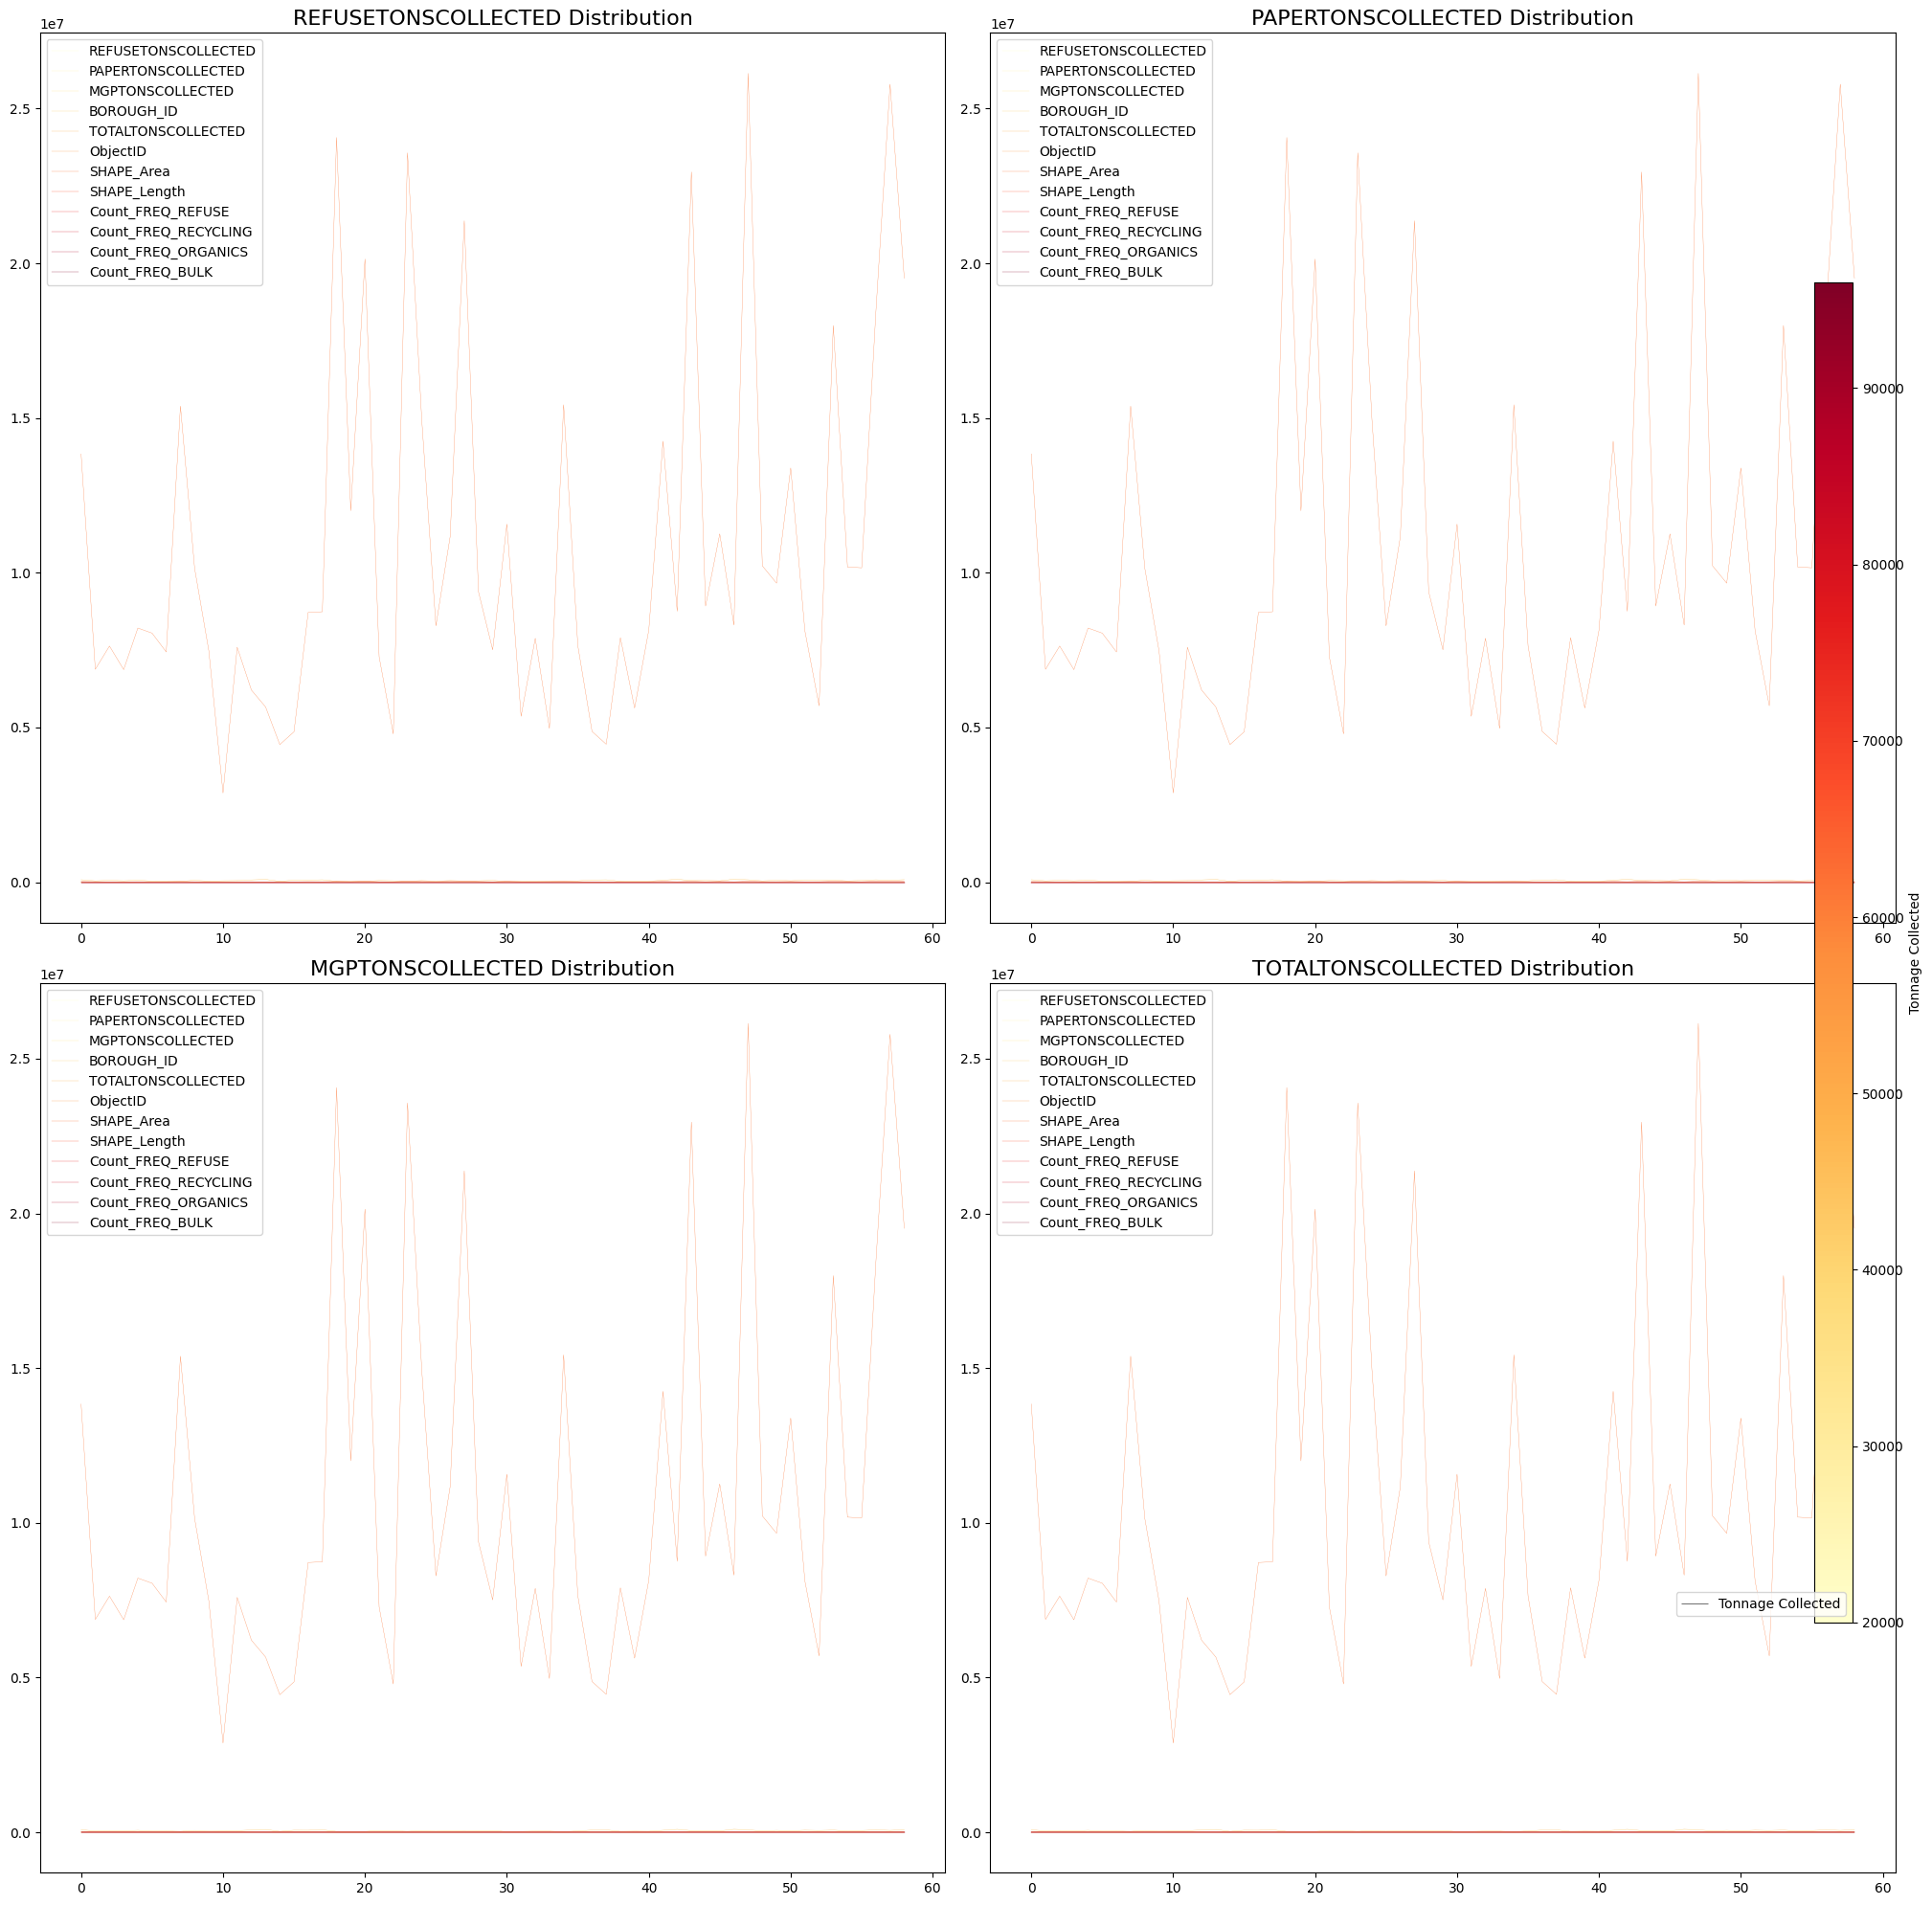

In [47]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Create a figure with 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot each map with the common colormap
maps = ['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 
        'MGPTONSCOLLECTED', 'TOTALTONSCOLLECTED']

for i, ax in enumerate(axs.flatten()):
    column = maps[i]
    # Plotting the data
    district_gdf_Freq_mt.plot(ax=ax, column=column, cmap='YlOrRd', legend=True,
                              linewidth=0.2)  # Removing legend_kwds parameter
    # Set the title using the name of the column
    ax.set_title(f'{column} Distribution', fontsize=16)
    ax.axis('on')  # or 'equal' if you want to maintain aspect ratio

# Add a common colorbar
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=district_gdf_Freq_mt[column].min(), vmax=district_gdf_Freq_mt[column].max()))
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Tonnage Collected')

# Add a legend
plt.legend(['Tonnage Collected'], loc='lower right')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()


In [48]:
district_gdf_geoinfo = gdf_Freq_with_count[['Borough', 'Extracted_District','geometry','point_count']]

In [49]:
df_mt_geo = df_mt.merge(district_gdf_geoinfo, 
                    left_on=['BOROUGH', 'COMMUNITYDISTRICT'], 
                    right_on=['Borough', 'Extracted_District'], how='left')

In [50]:
df_mt_geo.head()

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
0  2023 / 01   Brooklyn                09               2885.1   
1  2023 / 01   Brooklyn                05               4385.2   
2  2023 / 01      Bronx                11               2851.8   
3  2023 / 01      Bronx                10               2444.5   
4  2023 / 01  Manhattan                10               2554.2   

   PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  \
0               284.7             232.6         3.0              3402.4   
1               256.9             435.0         3.0              5077.1   
2               274.9             340.5         2.0              3467.2   
3               292.8             338.3         2.0              3075.6   
4               248.7             231.3         1.0              3034.2   

     Borough Extracted_District  \
0   Brooklyn                 09   
1   Brooklyn                 05   
2      Bronx                 11   
3      Bronx                 10   
4  Manhattan                 10   

                                            geometry  point_count  
0  POLYGON ((-73.95023 40.65536, -73.95030 40.655...          300  
1  POLYGON ((-73.87655 40.64264, -73.87683 40.642...          308  
2  POLYGON ((-73.84629 40.84437, -73.84629 40.844...          248  
3  MULTIPOLYGON (((-73.81334 40.81337, -73.81347 ...          252  
4  POLYGON ((-73.94177 40.80709, -73.94195 40.806...          576

import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the datasets have been loaded as follows based on the screenshots:
# district_gdf_Freq = gpd.read_file('path_to_garbage_collection_frequency_data')
# df_lb = pd.read_csv('path_to_litter_basket_data.csv')
# df_mt = pd.read_csv('path_to_monthly_trash_collection_data.csv')

# Integration and analysis
def integrate_and_analyze(gdf_freq, df_baskets, df_monthly_trash):
    # Integrate litter basket data with the frequency data on the district level
    df_baskets['COMMUNITYDISTRICT'] = df_baskets['SECTION'].str.extract('(\d+)')
    integrated_df = pd.merge(gdf_freq, df_baskets, how='left', left_on='DISTRICT', right_on='COMMUNITYDISTRICT')
    
integrated_df = pd.merge(integrated_df, df_monthly_trash, how='left', on=['BOROUGH', 'COMMUNITYDISTRICT'])
    
    # Conduct analysis on the integrated dataset
    # For instance, correlation between litter baskets and tons collected
correlation_matrix = integrated_df[['BASKETID', 'REFUSETONSCOLLECTED']].corr()
print('Correlation between the number of litter baskets and refuse tons collected:')
print(correlation_matrix)

    # Visualization: Number of litter baskets vs. refuse tons collected
sns.jointplot(x='BASKETID', y='REFUSETONSCOLLECTED', data=integrated_df, kind='scatter')
plt.show()

    # Group by borough and sum the total tons collected, then compare it to the number of baskets
borough_analysis = integrated_df.groupby('BOROUGH').agg({
    'BASKETID': 'count',
    'TOTALTONSCOLLECTED': 'sum'
 }).reset_index()

sns.barplot(x='BOROUGH', y='BASKETID', data=borough_analysis)
plt.title('Number of Litter Baskets by Borough')
plt.show()

sns.barplot(x='BOROUGH', y='TOTALTONSCOLLECTED', data=borough_analysis)
plt.title('Total Tons Collected by Borough')
plt.show()

# Perform the integration and analysis
integrate_and_analyze(district_gdf_Freq, df_lb, df_mt)

# Note: Ensure the data types for 'DISTRICT' and 'COMMUNITYDISTRICT' match across datasets for accurate merging.
# Replace the paths with your actual data file paths.
# This code assumes the datasets have been preloaded as per the variable names given in the screenshots.


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume district_gdf_Freq, df_lb, and df_mt are pre-loaded DataFrames corresponding to the datasets you mentioned
# Each dataframe should have columns consistent with the ones you've provided, and the necessary transformations should be done beforehand

# Integration of the three datasets
def integrate_datasets(gdf_freq, df_lb, df_mt):
    # Prepare the community district column for integration, making sure the format matches across all datasets
    df_lb['COMMUNITYDISTRICT'] = df_lb['SECTION'].str.extract('(\d+)')
    df_mt['COMMUNITYDISTRICT'] = df_mt['COMMUNITYDISTRICT'].apply(lambda x: str(x).zfill(2))

    # Merge litter basket data (df_lb) with collection frequency data (gdf_freq)
    integrated_df = pd.merge(
        left=gdf_freq,
        right=df_lb,
        left_on='Extracted_District',
        right_on='COMMUNITYDISTRICT',
        how='inner',
        suffixes=('_freq', '_lb')
    )

    # Merge the above with monthly trash collection data (df_mt)
    integrated_df = pd.merge(
        left=integrated_df,
        right=df_mt,
        left_on=['BOROUGH', 'COMMUNITYDISTRICT'],
        right_on=['BOROUGH', 'COMMUNITYDISTRICT'],
        how='inner'
    )

    return integrated_df

# Analyze the integrated dataset
def analyze_integrated_data(integrated_df):
    # Analysis 1: Correlation between the count of litter baskets and refuse tons collected
    sns.jointplot(
        data=integrated_df,
        x='Count_FREQ_REFUSE',
        y='REFUSETONSCOLLECTED',
        kind='reg'
    )
    plt.title('Correlation between Refuse Collection Frequency and Tons Collected')
    plt.xlabel('Count of Refuse Collection Frequency')
    plt.ylabel('Refuse Tons Collected')
    plt.show()

    # Analysis 2: Total tons collected by borough
    total_tons_by_borough = integrated_df.groupby('BOROUGH_freq')['TOTALTONSCOLLECTED'].sum().reset_index()
    sns.barplot(
        data=total_tons_by_borough,
        x='BOROUGH_freq',
        y='TOTALTONSCOLLECTED'
    )
    plt.title('Total Tons Collected by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Total Tons Collected')
    plt.xticks(rotation=45)
    plt.show()

    # More analyses can be added as required...

# Run the integration and analysis functions
integrated_data = integrate_datasets(district_gdf_Freq, df_lb, df_mt)
analyze_integrated_data(integrated_data)


In [51]:
df_mt

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
2834   2023 / 01   Brooklyn                09               2885.1   
2835   2023 / 01   Brooklyn                05               4385.2   
2836   2023 / 01      Bronx                11               2851.8   
2837   2023 / 01      Bronx                10               2444.5   
2838   2023 / 01  Manhattan                10               2554.2   
...          ...        ...               ...                  ...   
23479  2023 / 12     Queens                07               6434.3   
23518  2023 / 10  Manhattan                06               2835.2   
23532  2023 / 12   Brooklyn                15               4447.2   
23562  2023 / 12     Queens                08               3677.0   
23574  2023 / 12     Queens                12               6542.4   

       PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  
2834                284.7             232.6         3.0              3402.4  
2835                256.9             435.0         3.0              5077.1  
2836                274.9             340.5         2.0              3467.2  
2837                292.8             338.3         2.0              3075.6  
2838                248.7             231.3         1.0              3034.2  
...                   ...               ...         ...                 ...  
23479               849.2             765.1         4.0              8048.6  
23518               484.4             337.0         1.0              3656.6  
23532               582.2             488.3         3.0              5517.7  
23562               481.5             390.1         4.0              4548.6  
23574               561.6             930.8         4.0              8034.8  

[708 rows x 8 columns]

In [52]:
district_gdf_Freq['Extracted_District']

0     01
1     02
2     03
3     04
4     05
5     08
6     09
7     16
8     17
9     06
10    07
11    10
12    11
13    12
14    13
15    14
16    15
17    18
18    01
19    02
20    03
21    04
22    05
23    06
24    07
25    08
26    09
27    10
28    11
29    12
30    01
31    02
32    03
33    04
34    05
35    06
36    07
37    08
38    09
39    10
40    11
41    12
42    07
43    08
44    10
45    11
46    12
47    13
48    14
49    01
50    02
51    03
52    04
53    05
54    06
55    09
56    01
57    02
58    03
Name: Extracted_District, dtype: object

In [53]:
district_gdf_Freq_mt.head()

BOROUGH COMMUNITYDISTRICT  \
0  Brooklyn                01   
1  Brooklyn                02   
2  Brooklyn                03   
3  Brooklyn                04   
4  Brooklyn                05   

                                               MONTH  REFUSETONSCOLLECTED  \
0  2023 / 022023 / 052023 / 062023 / 032023 / 082...              66587.8   
1  2023 / 052023 / 042023 / 012023 / 022023 / 072...              32289.0   
2  2023 / 012023 / 032023 / 072023 / 082023 / 022...              49724.1   
3  2023 / 052023 / 062023 / 042023 / 022023 / 112...              38219.3   
4  2023 / 012023 / 032023 / 062023 / 082023 / 022...              55366.3   

   PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  \
0              7873.0            5020.4        36.0             79481.2   
1              6065.9            4659.4        36.0             43014.3   
2              5120.4            3876.0        36.0             58720.5   
3              2920.6            4223.0        36.0             45362.9   
4              2719.9            5140.7        36.0             63226.9   

  DISTRICT                                           geometry  ...  \
0    BKN01  POLYGON ((-73.94197 40.70066, -73.94198 40.700...  ...   
1    BKN02  POLYGON ((-73.95986 40.68815, -73.95971 40.687...  ...   
2    BKN03  POLYGON ((-73.91718 40.68318, -73.91717 40.683...  ...   
3    BKN04  POLYGON ((-73.90267 40.68052, -73.90267 40.680...  ...   
4    BKN05  POLYGON ((-73.87655 40.64264, -73.87683 40.642...  ...   

   SHAPE_Length                                       multipolygon  \
0  18943.619157  MULTIPOLYGON (((-73.9543390413 40.7140717022, ...   
1  13754.130867  MULTIPOLYGON (((-73.9747866386 40.6980048114, ...   
2  11325.838020  MULTIPOLYGON (((-73.9473105666 40.6858454855, ...   
3  11524.156089  MULTIPOLYGON (((-73.9218918474 40.7093960964, ...   
4  13470.744483  MULTIPOLYGON (((-73.8847034837 40.6722342021, ...   

  FREQ_RESFUSEID   Borough Extracted_District Extracted_Section  \
0      BKN012THS  Brooklyn                 01                 2   
1       BKN024MH  Brooklyn                 02                 4   
2      BKN032THS  Brooklyn                 03                 2   
3      BKN041THS  Brooklyn                 04                 1   
4       BKN051WS  Brooklyn                 05                 1   

  Count_FREQ_REFUSE  Count_FREQ_RECYCLING  Count_FREQ_ORGANICS  \
0                 3                     1                    1   
1                 2                     1                    1   
2                 3                     1                    1   
3                 3                     1                    1   
4                 2                     1                    1   

   Count_FREQ_BULK  
0                3  
1                2  
2                3  
3                3  
4                2  

[5 rows x 29 columns]

In [54]:
df_mt_geo

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
0    2023 / 01   Brooklyn                09               2885.1   
1    2023 / 01   Brooklyn                05               4385.2   
2    2023 / 01      Bronx                11               2851.8   
3    2023 / 01      Bronx                10               2444.5   
4    2023 / 01  Manhattan                10               2554.2   
..         ...        ...               ...                  ...   
703  2023 / 12     Queens                07               6434.3   
704  2023 / 10  Manhattan                06               2835.2   
705  2023 / 12   Brooklyn                15               4447.2   
706  2023 / 12     Queens                08               3677.0   
707  2023 / 12     Queens                12               6542.4   

     PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  \
0                 284.7             232.6         3.0              3402.4   
1                 256.9             435.0         3.0              5077.1   
2                 274.9             340.5         2.0              3467.2   
3                 292.8             338.3         2.0              3075.6   
4                 248.7             231.3         1.0              3034.2   
..                  ...               ...         ...                 ...   
703               849.2             765.1         4.0              8048.6   
704               484.4             337.0         1.0              3656.6   
705               582.2             488.3         3.0              5517.7   
706               481.5             390.1         4.0              4548.6   
707               561.6             930.8         4.0              8034.8   

       Borough Extracted_District  \
0     Brooklyn                 09   
1     Brooklyn                 05   
2        Bronx                 11   
3        Bronx                 10   
4    Manhattan                 10   
..         ...                ...   
703     Queens                 07   
704  Manhattan                 06   
705   Brooklyn                 15   
706     Queens                 08   
707     Queens                 12   

                                              geometry  point_count  
0    POLYGON ((-73.95023 40.65536, -73.95030 40.655...          300  
1    POLYGON ((-73.87655 40.64264, -73.87683 40.642...          308  
2    POLYGON ((-73.84629 40.84437, -73.84629 40.844...          248  
3    MULTIPOLYGON (((-73.81334 40.81337, -73.81347 ...          252  
4    POLYGON ((-73.94177 40.80709, -73.94195 40.806...          576  
..                                                 ...          ...  
703  MULTIPOLYGON (((-73.82520 40.74204, -73.82520 ...          392  
704  POLYGON ((-73.97363 40.73211, -73.97361 40.732...          719  
705  POLYGON ((-73.96067 40.58950, -73.96067 40.589...          340  
706  POLYGON ((-73.80659 40.70663, -73.80849 40.706...          266  
707  POLYGON ((-73.79003 40.66633, -73.79143 40.666...          478  

[708 rows x 12 columns]

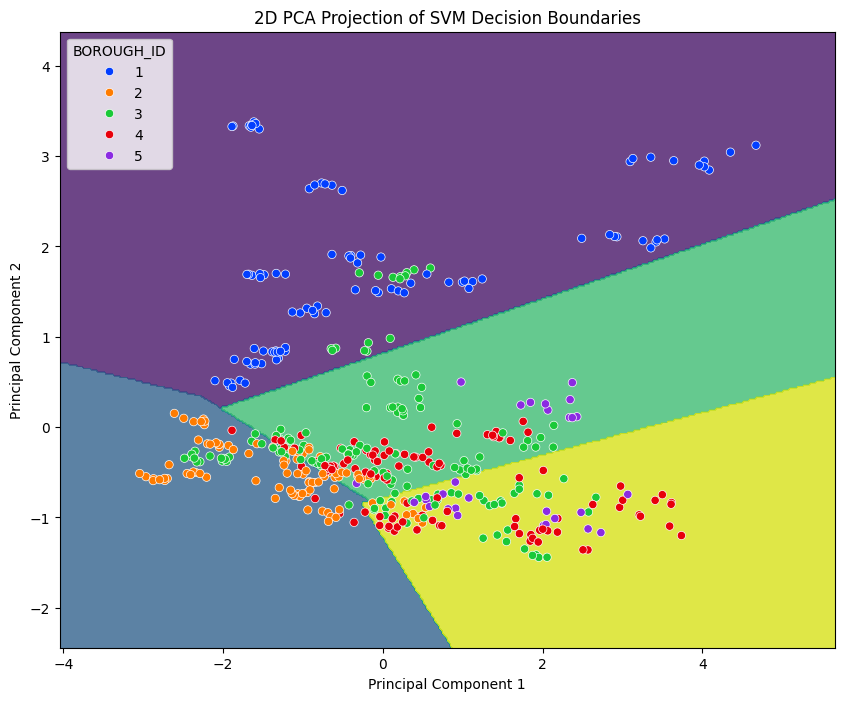

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        48
           2       0.65      0.74      0.69        42
           3       0.51      0.48      0.49        61
           4       0.62      0.58      0.60        55
           5       0.00      0.00      0.00         7

    accuracy                           0.66       213
   macro avg       0.53      0.56      0.54       213
weighted avg       0.63      0.66      0.64       213



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [55]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume df_mt_geo is the DataFrame we're working with

# Select features and target variable
features = ['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'point_count']
target = 'BOROUGH_ID'

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(df_mt_geo[features])
y = df_mt_geo[target].astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the SVM model
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Retrain the SVM model on the 2D projected data
clf_pca = svm.SVC(kernel='linear')
clf_pca.fit(X_train_pca, y_train)

# Plot decision boundaries in 2D
plt.figure(figsize=(10, 8))

# Create grid to evaluate model
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot boundaries
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)

# Plot also the training points
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='bright')
plt.title('2D PCA Projection of SVM Decision Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Make predictions and evaluate the model
y_pred = clf_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred))


/var/folders/6f/zr09xr8535b2gcqszfr916p00000gn/T/ipykernel_13008/255488141.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mt_geo['MONTH'] = pd.to_datetime(df_mt_geo['MONTH'])


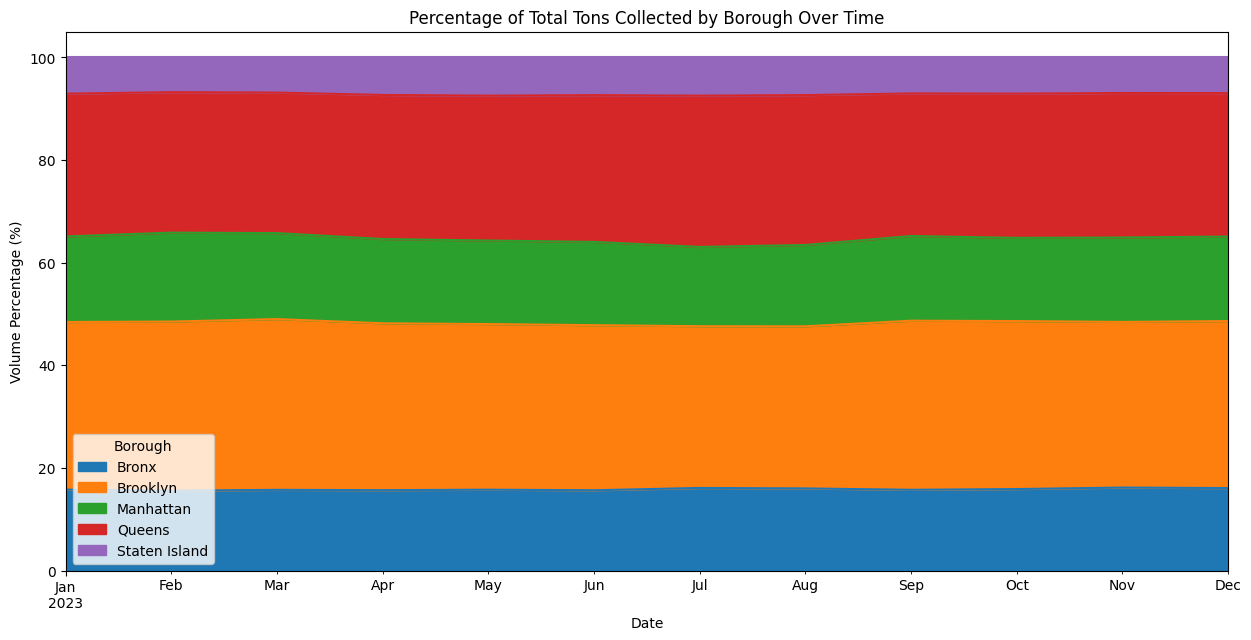

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Let's assume df_mt_geo is already loaded and contains the necessary columns

# First, convert 'MONTH' to a datetime to ensure proper sorting
df_mt_geo['MONTH'] = pd.to_datetime(df_mt_geo['MONTH'])

# Then, group the data by 'MONTH' and 'BOROUGH', and sum the 'TOTALTONSCOLLECTED'
grouped_data = df_mt_geo.groupby(['MONTH', 'BOROUGH']).agg({'TOTALTONSCOLLECTED': 'sum'}).reset_index()

# Pivot the data to have months as rows and boroughs as columns
pivot_data = grouped_data.pivot(index='MONTH', columns='BOROUGH', values='TOTALTONSCOLLECTED').fillna(0)

# Normalize the data by row to get the percentage
percentage_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plot the stacked area chart
percentage_data.plot(kind='area', stacked=True, figsize=(15, 7))
plt.title('Percentage of Total Tons Collected by Borough Over Time')
plt.xlabel('Date')
plt.ylabel('Volume Percentage (%)')
plt.legend(title='Borough')
plt.show()


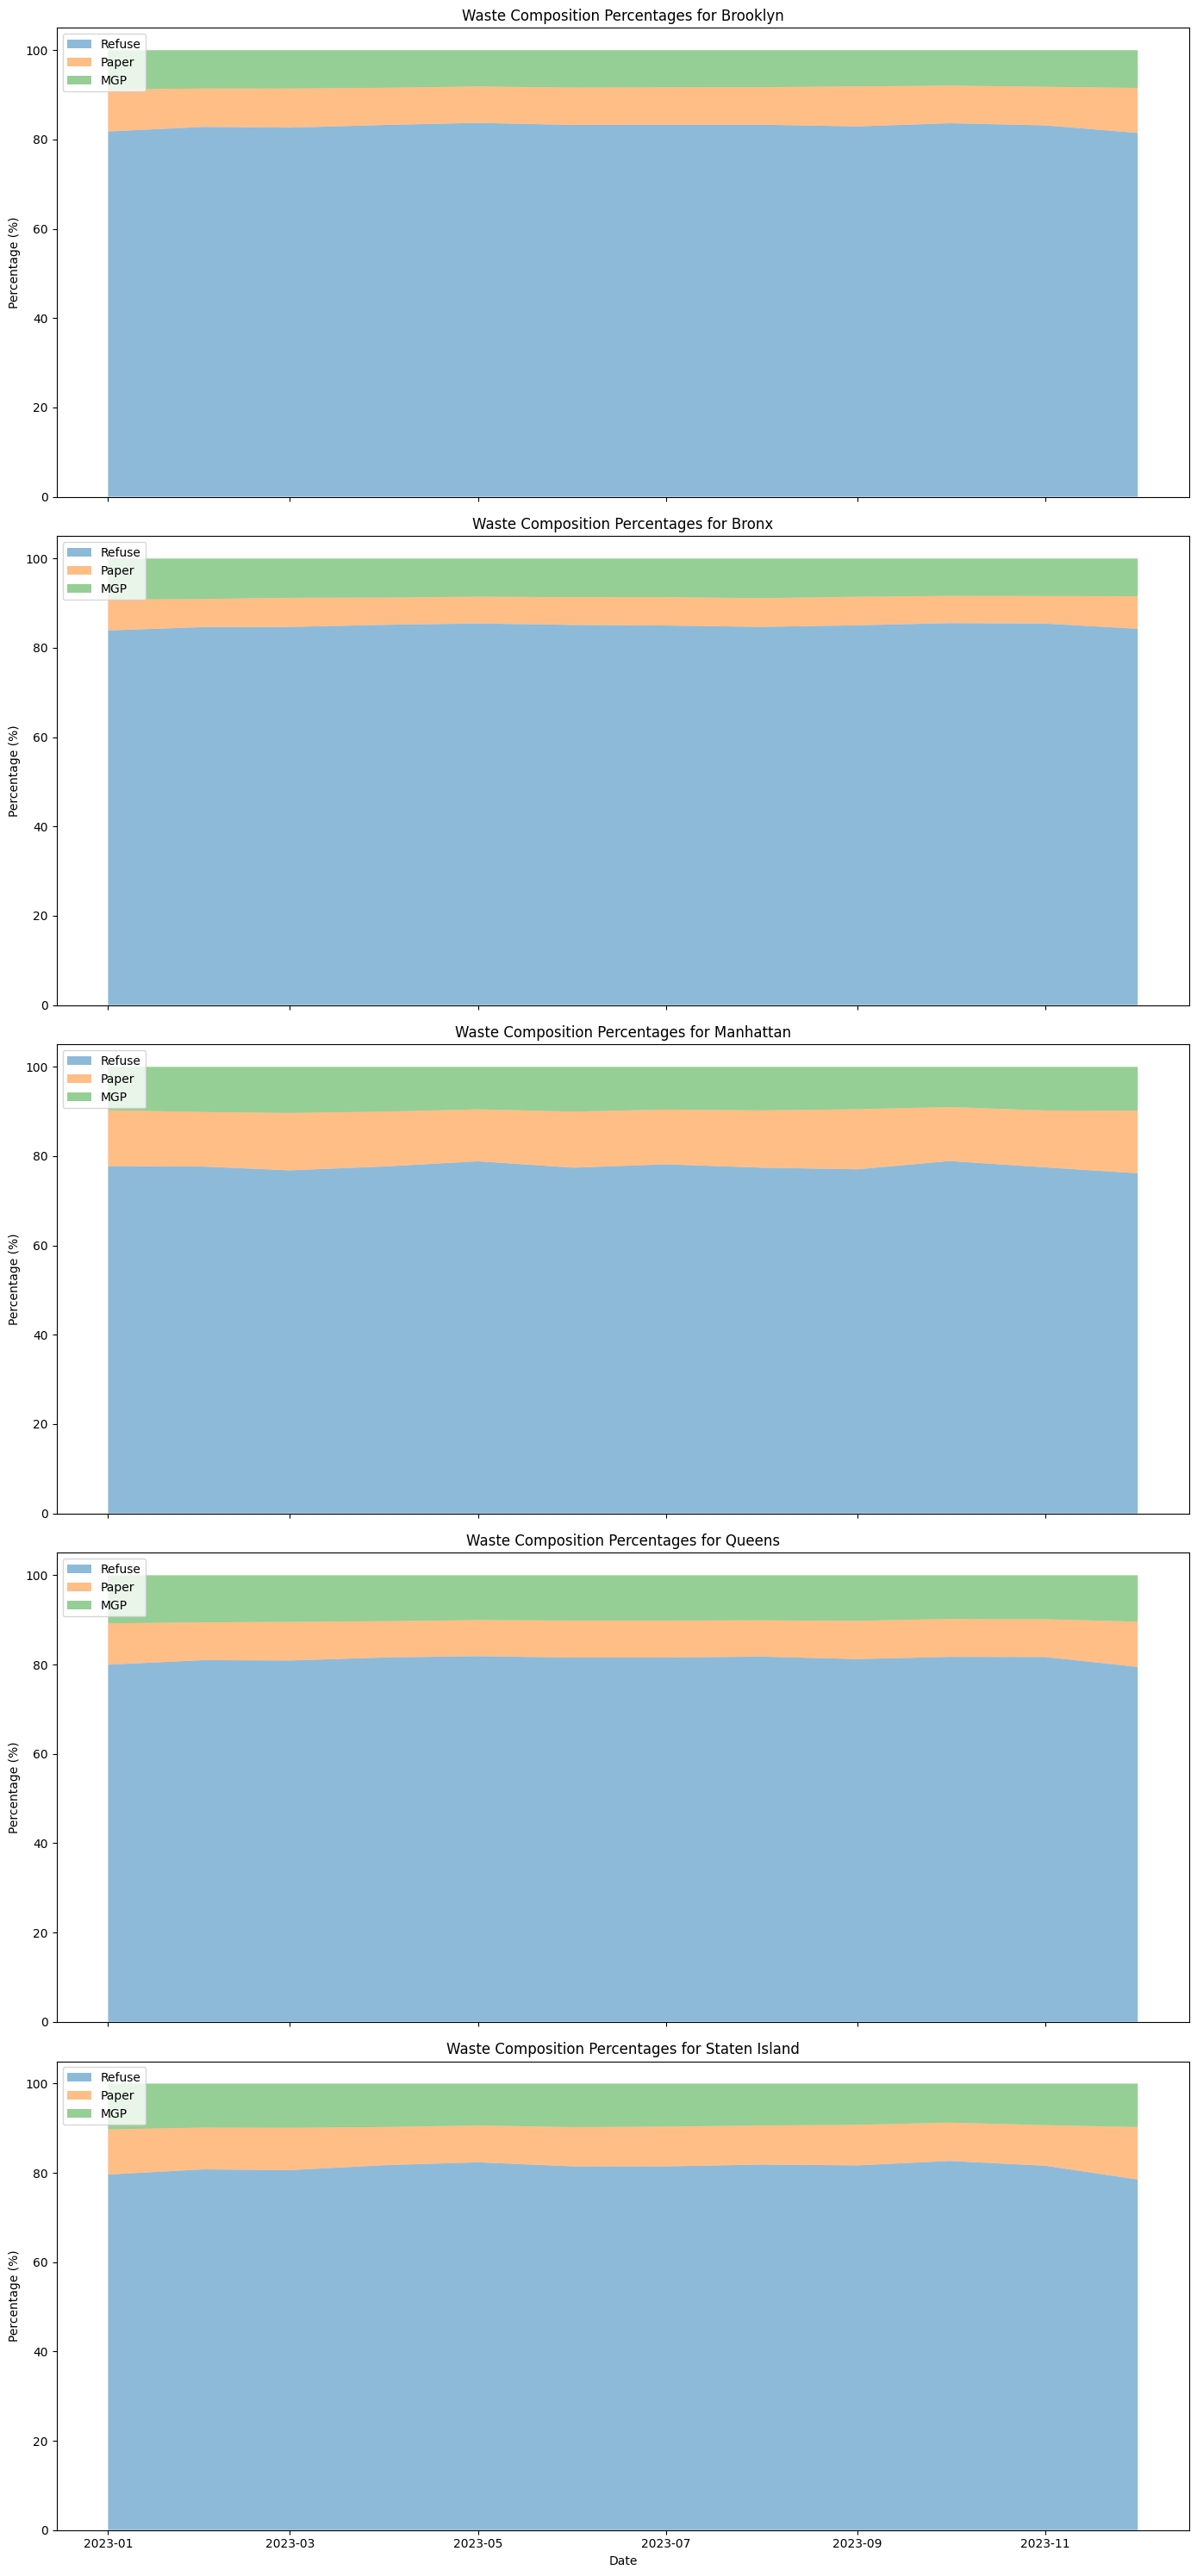

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_mt_geo is preloaded and has the MONTH column in the correct datetime format

# First, calculate the total of each waste type collected for each borough and month

# Now calculate the percentage of each waste type out of the total waste for that borough and month
df_mt_geo['PERC_REFUSE'] = df_mt_geo['REFUSETONSCOLLECTED'] / df_mt_geo['TOTALTONSCOLLECTED'] * 100
df_mt_geo['PERC_PAPER'] = df_mt_geo['PAPERTONSCOLLECTED'] / df_mt_geo['TOTALTONSCOLLECTED'] * 100
df_mt_geo['PERC_MGP'] = df_mt_geo['MGPTONSCOLLECTED'] / df_mt_geo['TOTALTONSCOLLECTED'] * 100

# Group by borough and month
grouped = df_mt_geo.groupby(['MONTH', 'BOROUGH']).agg({
    'PERC_REFUSE': 'mean',
    'PERC_PAPER': 'mean',
    'PERC_MGP': 'mean'
}).reset_index()

# Now create the area plots
boroughs = df_mt_geo['BOROUGH'].unique()
fig, axes = plt.subplots(nrows=len(boroughs), ncols=1, figsize=(14, 6 * len(boroughs)), sharex=True)

for i, borough in enumerate(boroughs):
    borough_data = grouped[grouped['BOROUGH'] == borough].set_index('MONTH')
    axes[i].stackplot(borough_data.index, 
                      borough_data['PERC_REFUSE'], 
                      borough_data['PERC_PAPER'], 
                      borough_data['PERC_MGP'],
                      labels=['Refuse', 'Paper', 'MGP'], 
                      alpha=0.5)
    axes[i].set_title(f'Waste Composition Percentages for {borough}')
    axes[i].legend(loc='upper left')
    axes[i].set_ylabel('Percentage (%)')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


In [58]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Assume df_mt_geo is the DataFrame and it's already loaded

# Features and target for the SVM
features = df_mt_geo[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']]
target = df_mt_geo['BOROUGH_ID']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

# Initialize and train the SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Print a classification report to see the results
print(classification_report(y_test, y_pred))

# No need for visualization code as you only asked for the classification code


              precision    recall  f1-score   support

         1.0       0.78      0.65      0.70        48
         2.0       0.59      0.93      0.72        42
         3.0       0.50      0.52      0.51        61
         4.0       0.79      0.47      0.59        55
         5.0       0.30      0.43      0.35         7

    accuracy                           0.62       213
   macro avg       0.59      0.60      0.58       213
weighted avg       0.65      0.62      0.61       213



In [59]:
df_mt_geo

MONTH    BOROUGH COMMUNITYDISTRICT  REFUSETONSCOLLECTED  \
0   2023-01-01   Brooklyn                09               2885.1   
1   2023-01-01   Brooklyn                05               4385.2   
2   2023-01-01      Bronx                11               2851.8   
3   2023-01-01      Bronx                10               2444.5   
4   2023-01-01  Manhattan                10               2554.2   
..         ...        ...               ...                  ...   
703 2023-12-01     Queens                07               6434.3   
704 2023-10-01  Manhattan                06               2835.2   
705 2023-12-01   Brooklyn                15               4447.2   
706 2023-12-01     Queens                08               3677.0   
707 2023-12-01     Queens                12               6542.4   

     PAPERTONSCOLLECTED  MGPTONSCOLLECTED  BOROUGH_ID  TOTALTONSCOLLECTED  \
0                 284.7             232.6         3.0              3402.4   
1                 256.9             435.0         3.0              5077.1   
2                 274.9             340.5         2.0              3467.2   
3                 292.8             338.3         2.0              3075.6   
4                 248.7             231.3         1.0              3034.2   
..                  ...               ...         ...                 ...   
703               849.2             765.1         4.0              8048.6   
704               484.4             337.0         1.0              3656.6   
705               582.2             488.3         3.0              5517.7   
706               481.5             390.1         4.0              4548.6   
707               561.6             930.8         4.0              8034.8   

       Borough Extracted_District  \
0     Brooklyn                 09   
1     Brooklyn                 05   
2        Bronx                 11   
3        Bronx                 10   
4    Manhattan                 10   
..         ...                ...   
703     Queens                 07   
704  Manhattan                 06   
705   Brooklyn                 15   
706     Queens                 08   
707     Queens                 12   

                                              geometry  point_count  \
0    POLYGON ((-73.95023 40.65536, -73.95030 40.655...          300   
1    POLYGON ((-73.87655 40.64264, -73.87683 40.642...          308   
2    POLYGON ((-73.84629 40.84437, -73.84629 40.844...          248   
3    MULTIPOLYGON (((-73.81334 40.81337, -73.81347 ...          252   
4    POLYGON ((-73.94177 40.80709, -73.94195 40.806...          576   
..                                                 ...          ...   
703  MULTIPOLYGON (((-73.82520 40.74204, -73.82520 ...          392   
704  POLYGON ((-73.97363 40.73211, -73.97361 40.732...          719   
705  POLYGON ((-73.96067 40.58950, -73.96067 40.589...          340   
706  POLYGON ((-73.80659 40.70663, -73.80849 40.706...          266   
707  POLYGON ((-73.79003 40.66633, -73.79143 40.666...          478   

     PERC_REFUSE  PERC_PAPER   PERC_MGP  
0      84.796026    8.367623   6.836351  
1      86.372142    5.059975   8.567883  
2      82.250808    7.928588   9.820605  
3      79.480427    9.520094  10.999480  
4      84.180344    8.196559   7.623097  
..           ...         ...        ...  
703    79.943096   10.550903   9.506001  
704    77.536509   13.247279   9.216212  
705    80.598800   10.551498   8.849702  
706    80.838060   10.585675   8.576265  
707    81.425798    6.989595  11.584607  

[708 rows x 15 columns]

In [60]:
df_mt_geo.columns

Index(['MONTH', 'BOROUGH', 'COMMUNITYDISTRICT', 'REFUSETONSCOLLECTED',
       'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED', 'BOROUGH_ID',
       'TOTALTONSCOLLECTED', 'Borough', 'Extracted_District', 'geometry',
       'point_count', 'PERC_REFUSE', 'PERC_PAPER', 'PERC_MGP'],
      dtype='object')

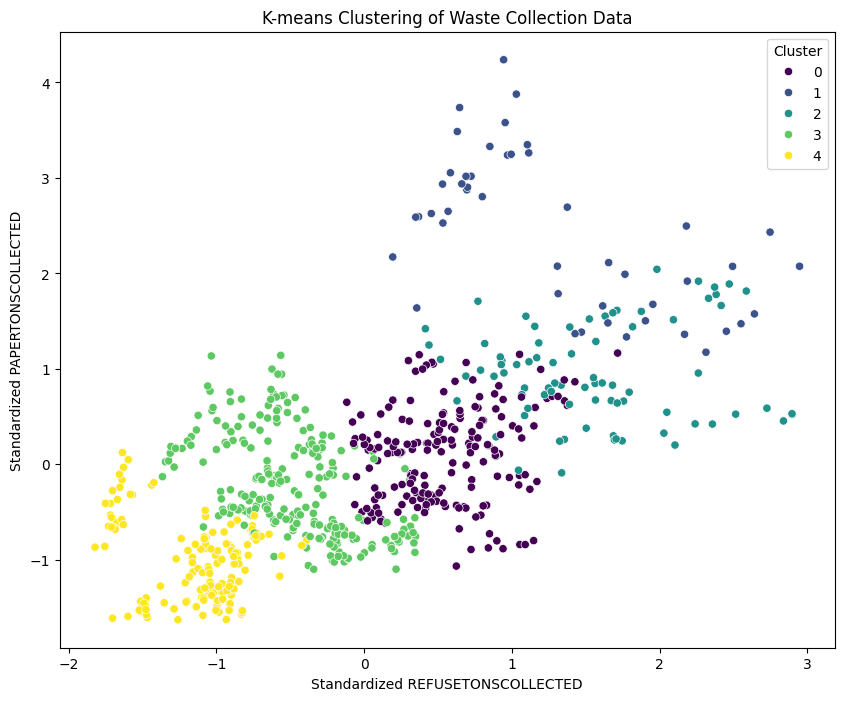

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假设 df_mt_geo 是预先加载的DataFrame，包含我们感兴趣的特征列

# 选择要进行聚类的特征
features = df_mt_geo[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']]

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 应用KMeans聚类
kmeans = KMeans(n_clusters=5, random_state=42)  # 假设我们根据数据选择了5个簇
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 绘制每个簇的2D散点图，只取前两个特征进行绘图
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis')
plt.title('K-means Clustering of Waste Collection Data')
plt.xlabel('Standardized REFUSETONSCOLLECTED')
plt.ylabel('Standardized PAPERTONSCOLLECTED')
plt.legend(title='Cluster')
plt.show()


In [62]:
# Assuming df_mt_geo is your DataFrame
df_mt_geo = df_mt_geo.drop(columns=['BOROUGH_ID', 'Borough'])


In [63]:
df_mt_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                708 non-null    datetime64[ns]
 1   BOROUGH              708 non-null    object        
 2   COMMUNITYDISTRICT    708 non-null    object        
 3   REFUSETONSCOLLECTED  708 non-null    float64       
 4   PAPERTONSCOLLECTED   708 non-null    float64       
 5   MGPTONSCOLLECTED     708 non-null    float64       
 6   TOTALTONSCOLLECTED   708 non-null    float64       
 7   Extracted_District   708 non-null    object        
 8   geometry             708 non-null    geometry      
 9   point_count          708 non-null    int64         
 10  PERC_REFUSE          708 non-null    float64       
 11  PERC_PAPER           708 non-null    float64       
 12  PERC_MGP             708 non-null    float64       
dtypes: datetime64[ns](1), float64(7), g

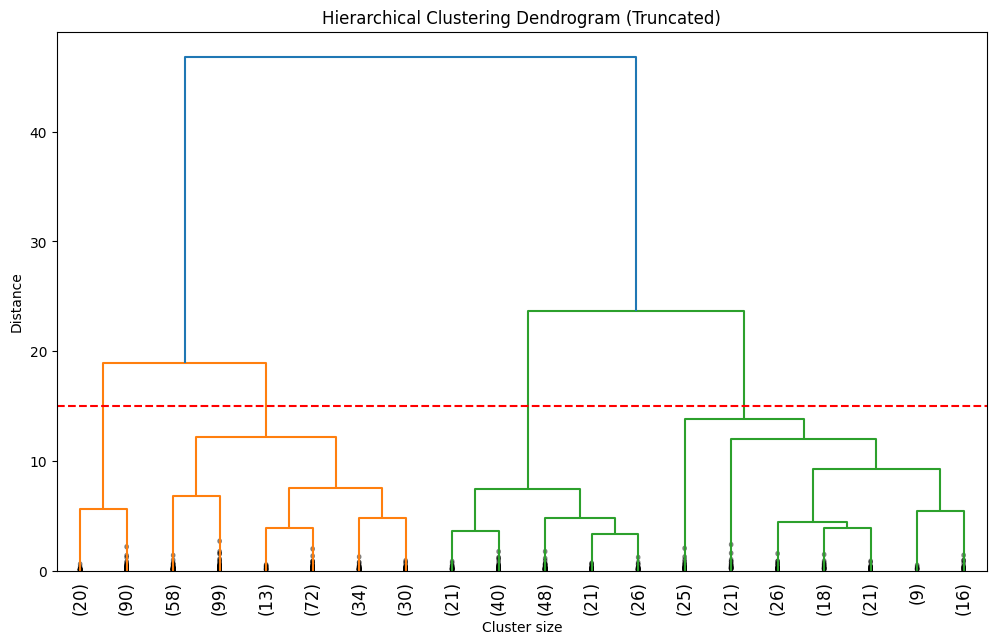

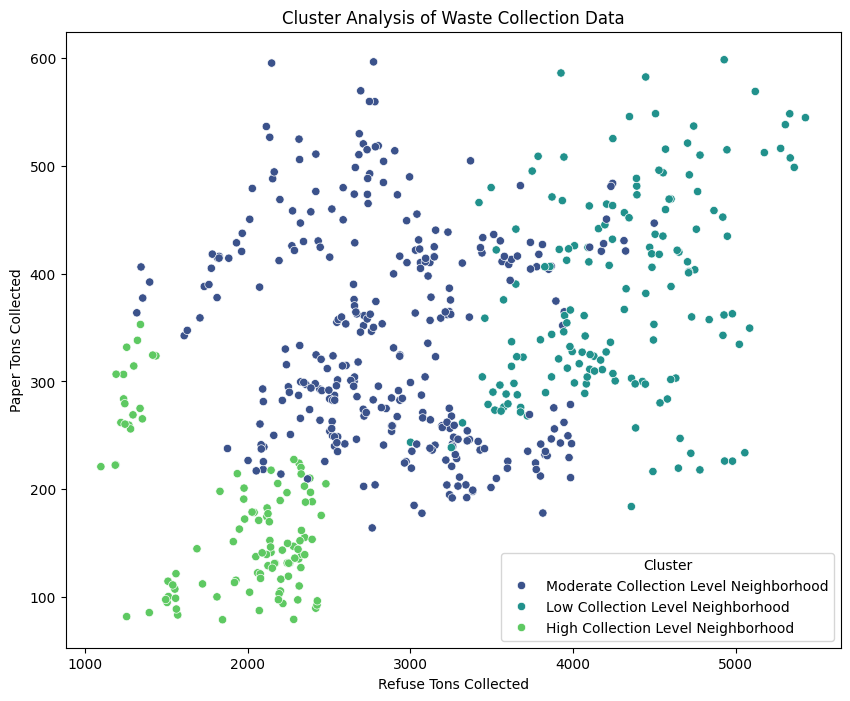

In [71]:
# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')

# Create a truncated dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=20,  # show only the last 20 merged clusters
           show_leaf_counts=True,
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True,
           color_threshold=25)

plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--')  # Draw line for cutting the dendrogram
plt.show()

# Determine clusters (cutting the dendrogram at height 15)
max_d = 15
clusters = fcluster(linked, max_d, criterion='distance')
df_mt_geo['Cluster'] = clusters

# Assign names based on cluster characteristics
cluster_names = {
    1: 'High Collection Level Neighborhood',
    2: 'Moderate Collection Level Neighborhood',
    3: 'Low Collection Level Neighborhood'
}
df_mt_geo['Cluster Name'] = df_mt_geo['Cluster'].map(cluster_names)

# Plotting clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='REFUSETONSCOLLECTED', y='PAPERTONSCOLLECTED', hue='Cluster Name', data=df_mt_geo, palette='viridis')
plt.title('Cluster Analysis of Waste Collection Data')
plt.xlabel('Refuse Tons Collected')
plt.ylabel('Paper Tons Collected')
plt.legend(title='Cluster')
plt.show()


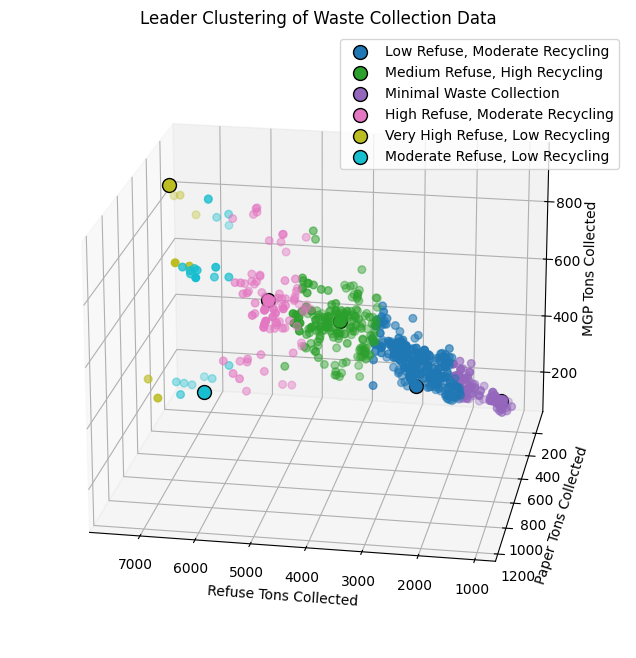

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_mt_geo is a pre-loaded DataFrame

# Remove rows with NaN values
df_mt_geo = df_mt_geo.dropna(subset=['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED'])

# Extract data for clustering
data = df_mt_geo[['REFUSETONSCOLLECTED', 'PAPERTONSCOLLECTED', 'MGPTONSCOLLECTED']].values

def leader_clustering(data, threshold):
    leaders = []
    clusters = []

    for point in data:
        if not leaders or all(np.linalg.norm(point - leader) > threshold for leader in leaders):
            leaders.append(point)
            clusters.append([point])
        else:
            distances = np.array([np.linalg.norm(point - leader) for leader in leaders])
            nearest = np.argmin(distances)
            clusters[nearest].append(point)

    return leaders, clusters

# Set clustering threshold
threshold = 1000  # Adjust the threshold to change the number of clusters

leaders, clusters = leader_clustering(data, threshold)

# Plotting 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))
cluster_names = [
    "Low Refuse, Moderate Recycling",
    "Medium Refuse, High Recycling",
    "Minimal Waste Collection",
    "High Refuse, Moderate Recycling",
    "Very High Refuse, Low Recycling",
    "Moderate Refuse, Low Recycling"
]

for idx, cluster in enumerate(clusters):
    cluster = np.array(cluster)
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], color=colors[idx], s=30)
    # Use simplified names without data for the legend
    leader_label = cluster_names[idx]
    ax.scatter(leaders[idx][0], leaders[idx][1], leaders[idx][2], color=colors[idx], s=100, edgecolors='k', label=leader_label)

ax.set_xlabel('Refuse Tons Collected')
ax.set_ylabel('Paper Tons Collected')
ax.set_zlabel('MGP Tons Collected')
ax.set_title('Leader Clustering of Waste Collection Data')
ax.legend()

# Adjust the viewing angle
ax.view_init(elev=20, azim=100)

plt.show()
